# Differential Vision Transformer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.nn import functional as F
from einops import rearrange, repeat
from tqdm import tqdm
import wandb

## Dataset

In [2]:
# download cifar10 dataset
transforms_def = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms_def)
testset = CIFAR10(root='./data', train=False, download=True, transform=transforms_def)

# split train to train and val
# trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

print("Training data:", len(trainset))
# print("Validation data:", len(valset))
print("Test data:", len(testset))

Training data: 50000
Test data: 10000


In [3]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
# val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

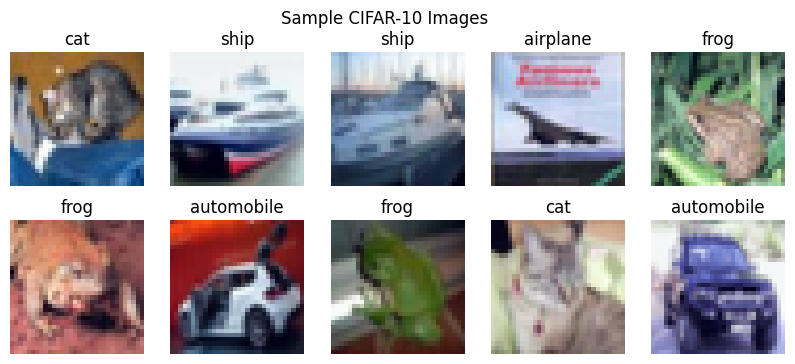

In [5]:
# visualize some data
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = testset[i][0].permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(cifar10_classes[testset[i][1]])
plt.suptitle('Sample CIFAR-10 Images')
plt.show()


## Model

In [5]:
# multi-head differential attention
class MultiHeadDifferentialAttention(nn.Module):
    def __init__(self, d_model, num_heads, layer_idx, dropout=0.0):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d = d_model // (2*num_heads) # for Q1, Q2, K1 and K2

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.lambda_init = 0.8 - 0.6 * torch.exp(torch.tensor(-0.3 * (layer_idx-1))).item()
        self.lambda_q1 = nn.Parameter(torch.randn(self.d))
        self.lambda_q2 = nn.Parameter(torch.randn(self.d))
        self.lambda_k1 = nn.Parameter(torch.randn(self.d))
        self.lambda_k2 = nn.Parameter(torch.randn(self.d))
        
        self.layer_idx = layer_idx
        self.dropout = nn.Dropout(dropout)
        
        self.group_norm = nn.GroupNorm(num_groups=num_heads, num_channels=self.d_model)
    
    def differential_attention(self, q1, q2, k1, k2, v):
        b, h, n, d = q1.shape
        s = 1 / (d**0.5)
        attn1 = torch.matmul(q1, k1.transpose(-1, -2)) * s
        attn2 = torch.matmul(q2, k2.transpose(-1, -2)) * s
        
        lambda_val = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1)) - torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2)) + self.lambda_init
        attn_weights = F.softmax(attn1, dim=-1) - lambda_val * F.softmax(attn2, dim=-1)
        output = torch.matmul(attn_weights, v)
        return output, attn_weights
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        
        q = self.W_q(x).reshape(batch_size, seq_len, self.num_heads*2, self.d).transpose(1,2)
        k = self.W_k(x).reshape(batch_size, seq_len, self.num_heads*2, self.d).transpose(1,2)
        v = self.W_v(x).reshape(batch_size, seq_len, self.num_heads, 2*self.d).transpose(1,2)
        
        q1, q2 = torch.split(q, self.num_heads, dim=1)
        k1, k2 = torch.split(k, self.num_heads, dim=1)
        
        attn_output, attn_weights = self.differential_attention(q1, q2, k1, k2, v)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, self.num_heads*2*self.d).transpose(1, 2)
        attn_output = self.group_norm(attn_output).transpose(1, 2)
        output = self.W_o(attn_output * (1 - self.lambda_init))
        output = self.dropout(output)
        return output, attn_weights
        
# mlp layer
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
    
# transformer encoder
class TransformerEncoderLayer(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, layer_idx, dropout=0.0):
        super(TransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(input_dim)
        self.mha = MultiHeadDifferentialAttention(input_dim, num_heads, layer_idx)
        self.norm2 = nn.LayerNorm(input_dim)
        self.mlp = MLP(input_dim, hidden_dim, input_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        self.attention_map = None
        
    def forward(self, x, mask=None):
        attn_output, attn_weights = self.mha(self.norm1(x), mask)
        self.attention_map = attn_weights
        x = x + self.dropout(attn_output)
        mlp_output = self.norm2(x)
        mlp_output = self.mlp(mlp_output)
        x = x + mlp_output
        return x

In [6]:
# diff-vit
class DiffVisionTransformer(nn.Module):
    def __init__(self, embedding_dim, num_heads, mlp_dim, num_encoders, patch_size=4, postional_embedding_type='1D', dropout=0.0):
        super(DiffVisionTransformer, self).__init__()
        self.num_patches = (32 // patch_size) ** 2
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.position_embedding_type = postional_embedding_type
        self.grid_size = 32 // patch_size
        
        
        self.patch_embedding = nn.Linear(3 * patch_size * patch_size, embedding_dim)
        match postional_embedding_type:
            case '1D':
                self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))
            case '2D':
                self.position_embedding_x = nn.Parameter(torch.randn(self.grid_size, embedding_dim // 2))
                self.position_embedding_y = nn.Parameter(torch.randn(self.grid_size, embedding_dim // 2))
            case 'sin':
                self.position_embedding = self._build_sinusoidal_positional_embedding(self.num_patches + 1, embedding_dim)
            case 'none':
                self.position_embedding = None

        # cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.dropout = nn.Dropout(dropout)
        
        self.transformer_encoder = nn.ModuleList([
            TransformerEncoderLayer(embedding_dim, num_heads, mlp_dim, i+1, dropout)
            for i in range(num_encoders)
        ])
        self.norm = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, 10)
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    def _build_sinusoidal_positional_embedding(self, seq_len, embed_dim):
        pos = torch.arange(seq_len)[:, None]
        i = torch.arange(embed_dim // 2)[None, :]
        angle_rates = 1 / (10000 ** (2 * i / embed_dim))
        angle_rads = pos * angle_rates
        pos_embedding = torch.zeros(seq_len, embed_dim)
        pos_embedding[:, 0::2] = torch.sin(angle_rads)
        pos_embedding[:, 1::2] = torch.cos(angle_rads)
        return nn.Parameter(pos_embedding.unsqueeze(0), requires_grad=False)
        
    def forward(self, x):
        # patches = rearrange(x, 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=self.patch_size, pw=self.patch_size)
        patches = self.unfold(x)  # shape: (B, C*patch_size*patch_size, N)
        patches = patches.transpose(1, 2)  # (B, N, patch_dim)
        patches = self.patch_embedding(patches)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=x.size(0))
        x = torch.cat((cls_tokens, patches), dim=1)
        if self.position_embedding_type != "none":
            if self.position_embedding_type == '2D':
                _y, _x = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
                x_pos = self.position_embedding_x[_x]
                y_pos = self.position_embedding_y[_y]
                pos_embedding = torch.cat((x_pos, y_pos), dim=-1).to(x.device)
                pos_embedding = pos_embedding.reshape(1, self.num_patches, self.embedding_dim).repeat(x.size(0), 1, 1)
                cls_pos = torch.zeros(x.size(0), 1, self.embedding_dim).to(x.device)
                pos_embedding = torch.cat((cls_pos, pos_embedding), dim=1)
                x = x + pos_embedding
            else:
                x = x + self.position_embedding
        for encoder in self.transformer_encoder:
            x = encoder(x)
        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

### Sample Run

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=50, log_wandb=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    # warmup type scheduler
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(tqdm(train_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Validate the model
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * val_correct / val_total:.2f}%')
        
        if log_wandb:
            wandb.log({
                'train_loss': running_loss / len(train_loader),
                'train_accuracy': 100 * correct / total,
                'val_loss': val_loss / len(val_loader),
                'val_accuracy': 100 * val_correct / val_total
            })
        
        # scheduler.step()
        
def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Loss: {running_loss/len(data_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

In [9]:
wandb.init(project='diff-vit-cifar10', name="test")
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96, 
    num_heads=4, 
    postional_embedding_type='1D',
    mlp_dim=192, 
    num_encoders=6, 
    dropout=0.2
)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 782/782 [00:33<00:00, 23.67it/s]


Epoch [1/50], Loss: 1.6364, Accuracy: 40.34%
Validation Loss: 1.4315, Validation Accuracy: 48.60%


100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


Epoch [2/50], Loss: 1.3735, Accuracy: 50.33%
Validation Loss: 1.3216, Validation Accuracy: 52.45%


100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [3/50], Loss: 1.2708, Accuracy: 54.02%
Validation Loss: 1.2474, Validation Accuracy: 54.86%


100%|██████████| 782/782 [00:32<00:00, 24.14it/s]


Epoch [4/50], Loss: 1.2093, Accuracy: 56.20%
Validation Loss: 1.2023, Validation Accuracy: 56.28%


100%|██████████| 782/782 [00:32<00:00, 24.00it/s]


Epoch [5/50], Loss: 1.1541, Accuracy: 58.51%
Validation Loss: 1.1838, Validation Accuracy: 57.30%


100%|██████████| 782/782 [00:32<00:00, 23.78it/s]


Epoch [6/50], Loss: 1.1018, Accuracy: 60.19%
Validation Loss: 1.1552, Validation Accuracy: 58.36%


100%|██████████| 782/782 [00:32<00:00, 24.03it/s]


Epoch [7/50], Loss: 1.0592, Accuracy: 62.06%
Validation Loss: 1.1258, Validation Accuracy: 59.69%


100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


Epoch [8/50], Loss: 1.0164, Accuracy: 63.66%
Validation Loss: 1.0818, Validation Accuracy: 60.94%


100%|██████████| 782/782 [00:31<00:00, 24.67it/s]


Epoch [9/50], Loss: 0.9866, Accuracy: 64.57%
Validation Loss: 1.0860, Validation Accuracy: 61.13%


100%|██████████| 782/782 [00:31<00:00, 24.54it/s]


Epoch [10/50], Loss: 0.9491, Accuracy: 65.92%
Validation Loss: 1.0737, Validation Accuracy: 61.85%


100%|██████████| 782/782 [00:31<00:00, 24.92it/s]


Epoch [11/50], Loss: 0.9202, Accuracy: 67.15%
Validation Loss: 1.0798, Validation Accuracy: 62.21%


100%|██████████| 782/782 [00:32<00:00, 24.28it/s]


Epoch [12/50], Loss: 0.8887, Accuracy: 68.03%
Validation Loss: 1.0526, Validation Accuracy: 63.32%


100%|██████████| 782/782 [00:32<00:00, 24.23it/s]


Epoch [13/50], Loss: 0.8560, Accuracy: 69.33%
Validation Loss: 1.0605, Validation Accuracy: 63.43%


100%|██████████| 782/782 [00:31<00:00, 24.49it/s]


Epoch [14/50], Loss: 0.8298, Accuracy: 70.22%
Validation Loss: 1.0660, Validation Accuracy: 63.41%


100%|██████████| 782/782 [00:31<00:00, 24.83it/s]


Epoch [15/50], Loss: 0.8058, Accuracy: 71.26%
Validation Loss: 1.0592, Validation Accuracy: 63.50%


100%|██████████| 782/782 [00:32<00:00, 24.25it/s]


Epoch [16/50], Loss: 0.7819, Accuracy: 71.90%
Validation Loss: 1.0427, Validation Accuracy: 64.63%


100%|██████████| 782/782 [00:32<00:00, 24.28it/s]


Epoch [17/50], Loss: 0.7537, Accuracy: 73.04%
Validation Loss: 1.0482, Validation Accuracy: 64.66%


100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch [18/50], Loss: 0.7313, Accuracy: 73.76%
Validation Loss: 1.0403, Validation Accuracy: 64.76%


100%|██████████| 782/782 [00:32<00:00, 23.98it/s]


Epoch [19/50], Loss: 0.7101, Accuracy: 74.54%
Validation Loss: 1.0789, Validation Accuracy: 64.25%


100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


Epoch [20/50], Loss: 0.6894, Accuracy: 75.25%
Validation Loss: 1.0362, Validation Accuracy: 65.19%


100%|██████████| 782/782 [00:32<00:00, 24.01it/s]


Epoch [21/50], Loss: 0.6683, Accuracy: 75.80%
Validation Loss: 1.1008, Validation Accuracy: 64.01%


100%|██████████| 782/782 [00:32<00:00, 24.05it/s]


Epoch [22/50], Loss: 0.6459, Accuracy: 76.63%
Validation Loss: 1.0596, Validation Accuracy: 65.33%


100%|██████████| 782/782 [00:32<00:00, 24.19it/s]


Epoch [23/50], Loss: 0.6255, Accuracy: 77.45%
Validation Loss: 1.0855, Validation Accuracy: 64.65%


100%|██████████| 782/782 [00:32<00:00, 24.11it/s]


Epoch [24/50], Loss: 0.6152, Accuracy: 77.79%
Validation Loss: 1.0660, Validation Accuracy: 65.28%


100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


Epoch [25/50], Loss: 0.5886, Accuracy: 78.74%
Validation Loss: 1.0917, Validation Accuracy: 65.06%


100%|██████████| 782/782 [00:31<00:00, 24.97it/s]


Epoch [26/50], Loss: 0.5721, Accuracy: 79.32%
Validation Loss: 1.1015, Validation Accuracy: 64.85%


100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [27/50], Loss: 0.5577, Accuracy: 80.00%
Validation Loss: 1.1086, Validation Accuracy: 65.04%


100%|██████████| 782/782 [00:32<00:00, 24.15it/s]


Epoch [28/50], Loss: 0.5446, Accuracy: 80.22%
Validation Loss: 1.1076, Validation Accuracy: 65.03%


100%|██████████| 782/782 [00:31<00:00, 24.73it/s]


Epoch [29/50], Loss: 0.5233, Accuracy: 81.18%
Validation Loss: 1.1115, Validation Accuracy: 65.32%


100%|██████████| 782/782 [00:32<00:00, 24.05it/s]


Epoch [30/50], Loss: 0.5126, Accuracy: 81.24%
Validation Loss: 1.1252, Validation Accuracy: 65.42%


100%|██████████| 782/782 [00:32<00:00, 23.79it/s]


Epoch [31/50], Loss: 0.4940, Accuracy: 82.08%
Validation Loss: 1.1548, Validation Accuracy: 65.77%


100%|██████████| 782/782 [00:32<00:00, 23.73it/s]


Epoch [32/50], Loss: 0.4802, Accuracy: 82.51%
Validation Loss: 1.1040, Validation Accuracy: 66.04%


100%|██████████| 782/782 [00:32<00:00, 23.78it/s]


Epoch [33/50], Loss: 0.4637, Accuracy: 83.18%
Validation Loss: 1.1686, Validation Accuracy: 65.88%


100%|██████████| 782/782 [00:32<00:00, 23.89it/s]


Epoch [34/50], Loss: 0.4544, Accuracy: 83.63%
Validation Loss: 1.1720, Validation Accuracy: 65.82%


100%|██████████| 782/782 [00:33<00:00, 23.55it/s]


Epoch [35/50], Loss: 0.4386, Accuracy: 84.11%
Validation Loss: 1.1868, Validation Accuracy: 65.89%


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [36/50], Loss: 0.4324, Accuracy: 84.26%
Validation Loss: 1.2047, Validation Accuracy: 65.72%


100%|██████████| 782/782 [00:31<00:00, 24.53it/s]


Epoch [37/50], Loss: 0.4229, Accuracy: 84.54%
Validation Loss: 1.1855, Validation Accuracy: 65.36%


100%|██████████| 782/782 [00:32<00:00, 24.31it/s]


Epoch [38/50], Loss: 0.4066, Accuracy: 85.17%
Validation Loss: 1.2535, Validation Accuracy: 65.28%


100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


Epoch [39/50], Loss: 0.3993, Accuracy: 85.53%
Validation Loss: 1.2047, Validation Accuracy: 66.48%


100%|██████████| 782/782 [00:32<00:00, 24.22it/s]


Epoch [40/50], Loss: 0.3899, Accuracy: 85.78%
Validation Loss: 1.2461, Validation Accuracy: 66.23%


100%|██████████| 782/782 [00:35<00:00, 21.88it/s]


Epoch [41/50], Loss: 0.3800, Accuracy: 86.10%
Validation Loss: 1.2510, Validation Accuracy: 65.88%


100%|██████████| 782/782 [00:38<00:00, 20.55it/s]


Epoch [42/50], Loss: 0.3667, Accuracy: 86.64%
Validation Loss: 1.2907, Validation Accuracy: 66.08%


100%|██████████| 782/782 [00:37<00:00, 20.97it/s]


Epoch [43/50], Loss: 0.3626, Accuracy: 86.73%
Validation Loss: 1.2683, Validation Accuracy: 66.33%


100%|██████████| 782/782 [00:36<00:00, 21.14it/s]


Epoch [44/50], Loss: 0.3524, Accuracy: 87.11%
Validation Loss: 1.3429, Validation Accuracy: 65.28%


100%|██████████| 782/782 [00:37<00:00, 20.88it/s]


Epoch [45/50], Loss: 0.3427, Accuracy: 87.62%
Validation Loss: 1.3110, Validation Accuracy: 65.52%


100%|██████████| 782/782 [00:36<00:00, 21.66it/s]


Epoch [46/50], Loss: 0.3417, Accuracy: 87.48%
Validation Loss: 1.2956, Validation Accuracy: 65.76%


100%|██████████| 782/782 [00:38<00:00, 20.57it/s]


Epoch [47/50], Loss: 0.3293, Accuracy: 87.91%
Validation Loss: 1.3330, Validation Accuracy: 65.93%


100%|██████████| 782/782 [00:40<00:00, 19.53it/s]


Epoch [48/50], Loss: 0.3230, Accuracy: 88.23%
Validation Loss: 1.3451, Validation Accuracy: 65.19%


100%|██████████| 782/782 [00:31<00:00, 24.51it/s]


Epoch [49/50], Loss: 0.3104, Accuracy: 88.70%
Validation Loss: 1.3600, Validation Accuracy: 66.13%


100%|██████████| 782/782 [00:31<00:00, 24.83it/s]


Epoch [50/50], Loss: 0.3154, Accuracy: 88.59%
Validation Loss: 1.3137, Validation Accuracy: 66.26%


train_accuracy,▁▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇███████████████▇█
val_loss,█▆▅▄▄▃▂▂▂▁▂▁▁▁▁▁▂▁▂▂▂▂▂▂▃▂▃▃▄▄▅▄▅▅▆▆▆▆▆▆
train_accuracy,88.594
train_loss,0.31545
val_accuracy,66.26
val_loss,1.3137


## Experiments

### Hyperparameter Tuning

In [ ]:
configs = [
    {
        'patch_size': 4,
        'embedding_dim': 96,
        'num_heads': 4,
        'mlp_dim': 192,
        'num_encoders': 6,
        'dropout': 0.2 
    },
    {
        'patch_size': 4,
        'embedding_dim': 48,
        'num_heads': 2,
        'mlp_dim': 48,
        'num_encoders': 4,
        'dropout': 0.2
    },
    {
        'patch_size': 4,
        'embedding_dim': 48,
        'num_heads': 8,
        'mlp_dim': 96,
        'num_encoders': 6,
        'dropout': 0.2
    },
    {
        'patch_size': 4,
        'embedding_dim': 96,
        'num_heads': 2,
        'mlp_dim': 96,
        'num_encoders': 2,
        'dropout': 0.2
    },
]
for config in configs:
    model = DiffVisionTransformer(**config)
    wandb.init(project='diff-vit-cifar10', name="vit-{}".format(config), config=config)
    train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
    wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 782/782 [00:27<00:00, 28.84it/s]


Epoch [1/50], Loss: 1.7808, Accuracy: 34.66%
Validation Loss: 1.5669, Validation Accuracy: 43.04%


100%|██████████| 782/782 [00:25<00:00, 30.10it/s]


Epoch [2/50], Loss: 1.5085, Accuracy: 45.00%
Validation Loss: 1.4100, Validation Accuracy: 49.76%


100%|██████████| 782/782 [00:25<00:00, 30.35it/s]


Epoch [3/50], Loss: 1.4065, Accuracy: 49.03%
Validation Loss: 1.3534, Validation Accuracy: 51.35%


100%|██████████| 782/782 [00:26<00:00, 29.84it/s]


Epoch [4/50], Loss: 1.3462, Accuracy: 51.28%
Validation Loss: 1.3134, Validation Accuracy: 52.68%


100%|██████████| 782/782 [00:26<00:00, 29.87it/s]


Epoch [5/50], Loss: 1.2967, Accuracy: 52.91%
Validation Loss: 1.2893, Validation Accuracy: 53.75%


100%|██████████| 782/782 [00:26<00:00, 29.73it/s]


Epoch [6/50], Loss: 1.2559, Accuracy: 54.58%
Validation Loss: 1.2530, Validation Accuracy: 54.62%


100%|██████████| 782/782 [00:26<00:00, 29.90it/s]


Epoch [7/50], Loss: 1.2302, Accuracy: 55.63%
Validation Loss: 1.2216, Validation Accuracy: 55.71%


100%|██████████| 782/782 [00:26<00:00, 29.88it/s]


Epoch [8/50], Loss: 1.1991, Accuracy: 56.82%
Validation Loss: 1.2053, Validation Accuracy: 56.18%


100%|██████████| 782/782 [00:25<00:00, 30.93it/s]


Epoch [9/50], Loss: 1.1755, Accuracy: 57.75%
Validation Loss: 1.1776, Validation Accuracy: 57.52%


100%|██████████| 782/782 [00:25<00:00, 30.38it/s]


Epoch [10/50], Loss: 1.1506, Accuracy: 58.57%
Validation Loss: 1.1576, Validation Accuracy: 58.11%


100%|██████████| 782/782 [00:24<00:00, 31.56it/s]


Epoch [11/50], Loss: 1.1327, Accuracy: 59.22%
Validation Loss: 1.1957, Validation Accuracy: 56.97%


100%|██████████| 782/782 [00:26<00:00, 29.57it/s]


Epoch [12/50], Loss: 1.1137, Accuracy: 59.93%
Validation Loss: 1.1548, Validation Accuracy: 58.11%


100%|██████████| 782/782 [00:24<00:00, 31.85it/s]


Epoch [13/50], Loss: 1.0968, Accuracy: 60.45%
Validation Loss: 1.1249, Validation Accuracy: 59.12%


100%|██████████| 782/782 [00:24<00:00, 31.47it/s]


Epoch [14/50], Loss: 1.0790, Accuracy: 61.18%
Validation Loss: 1.1499, Validation Accuracy: 58.72%


100%|██████████| 782/782 [00:25<00:00, 30.98it/s]


Epoch [15/50], Loss: 1.0647, Accuracy: 61.69%
Validation Loss: 1.1228, Validation Accuracy: 59.46%


100%|██████████| 782/782 [00:26<00:00, 29.97it/s]


Epoch [16/50], Loss: 1.0462, Accuracy: 62.13%
Validation Loss: 1.1126, Validation Accuracy: 60.18%


100%|██████████| 782/782 [00:26<00:00, 29.51it/s]


Epoch [17/50], Loss: 1.0333, Accuracy: 62.83%
Validation Loss: 1.1367, Validation Accuracy: 60.00%


100%|██████████| 782/782 [00:26<00:00, 29.37it/s]


Epoch [18/50], Loss: 1.0210, Accuracy: 63.34%
Validation Loss: 1.0967, Validation Accuracy: 60.45%


100%|██████████| 782/782 [00:26<00:00, 30.03it/s]


Epoch [19/50], Loss: 1.0064, Accuracy: 63.70%
Validation Loss: 1.0912, Validation Accuracy: 60.43%


100%|██████████| 782/782 [00:26<00:00, 29.98it/s]


Epoch [20/50], Loss: 0.9964, Accuracy: 64.23%
Validation Loss: 1.0848, Validation Accuracy: 61.49%


100%|██████████| 782/782 [00:26<00:00, 29.75it/s]


Epoch [21/50], Loss: 0.9858, Accuracy: 64.49%
Validation Loss: 1.0814, Validation Accuracy: 61.57%


100%|██████████| 782/782 [00:26<00:00, 29.56it/s]


Epoch [22/50], Loss: 0.9735, Accuracy: 65.06%
Validation Loss: 1.0677, Validation Accuracy: 61.89%


100%|██████████| 782/782 [00:26<00:00, 30.07it/s]


Epoch [23/50], Loss: 0.9652, Accuracy: 65.52%
Validation Loss: 1.0654, Validation Accuracy: 62.00%


100%|██████████| 782/782 [00:26<00:00, 29.81it/s]


Epoch [24/50], Loss: 0.9534, Accuracy: 65.99%
Validation Loss: 1.0725, Validation Accuracy: 62.00%


100%|██████████| 782/782 [00:26<00:00, 29.94it/s]


Epoch [25/50], Loss: 0.9446, Accuracy: 66.19%
Validation Loss: 1.0468, Validation Accuracy: 62.69%


100%|██████████| 782/782 [00:26<00:00, 29.77it/s]


Epoch [26/50], Loss: 0.9348, Accuracy: 66.41%
Validation Loss: 1.0605, Validation Accuracy: 62.49%


100%|██████████| 782/782 [00:26<00:00, 29.58it/s]


Epoch [27/50], Loss: 0.9285, Accuracy: 66.53%
Validation Loss: 1.0332, Validation Accuracy: 63.08%


100%|██████████| 782/782 [00:26<00:00, 29.59it/s]


Epoch [28/50], Loss: 0.9146, Accuracy: 67.20%
Validation Loss: 1.0565, Validation Accuracy: 62.74%


100%|██████████| 782/782 [00:26<00:00, 29.52it/s]


Epoch [29/50], Loss: 0.9076, Accuracy: 67.20%
Validation Loss: 1.0417, Validation Accuracy: 63.23%


100%|██████████| 782/782 [00:26<00:00, 29.65it/s]


Epoch [30/50], Loss: 0.9052, Accuracy: 67.32%
Validation Loss: 1.0404, Validation Accuracy: 63.33%


100%|██████████| 782/782 [00:26<00:00, 29.71it/s]


Epoch [31/50], Loss: 0.8920, Accuracy: 67.86%
Validation Loss: 1.0842, Validation Accuracy: 61.60%


100%|██████████| 782/782 [00:26<00:00, 29.31it/s]


Epoch [32/50], Loss: 0.8883, Accuracy: 68.14%
Validation Loss: 1.0356, Validation Accuracy: 63.81%


100%|██████████| 782/782 [00:26<00:00, 29.55it/s]


Epoch [33/50], Loss: 0.8825, Accuracy: 68.15%
Validation Loss: 1.0353, Validation Accuracy: 63.82%


100%|██████████| 782/782 [00:26<00:00, 29.95it/s]


Epoch [34/50], Loss: 0.8745, Accuracy: 68.50%
Validation Loss: 1.0570, Validation Accuracy: 62.91%


100%|██████████| 782/782 [00:26<00:00, 29.72it/s]


Epoch [35/50], Loss: 0.8653, Accuracy: 68.81%
Validation Loss: 1.0303, Validation Accuracy: 63.30%


100%|██████████| 782/782 [00:26<00:00, 29.60it/s]


Epoch [36/50], Loss: 0.8595, Accuracy: 69.04%
Validation Loss: 1.0347, Validation Accuracy: 63.61%


100%|██████████| 782/782 [00:26<00:00, 29.56it/s]


Epoch [37/50], Loss: 0.8522, Accuracy: 69.41%
Validation Loss: 1.0178, Validation Accuracy: 64.54%


100%|██████████| 782/782 [00:26<00:00, 29.71it/s]


Epoch [38/50], Loss: 0.8494, Accuracy: 69.40%
Validation Loss: 1.0560, Validation Accuracy: 62.87%


100%|██████████| 782/782 [00:26<00:00, 29.41it/s]


Epoch [39/50], Loss: 0.8398, Accuracy: 69.78%
Validation Loss: 1.0410, Validation Accuracy: 63.64%


100%|██████████| 782/782 [00:26<00:00, 29.73it/s]


Epoch [40/50], Loss: 0.8366, Accuracy: 69.91%
Validation Loss: 1.0396, Validation Accuracy: 63.77%


100%|██████████| 782/782 [00:28<00:00, 27.33it/s]


Epoch [41/50], Loss: 0.8275, Accuracy: 70.08%
Validation Loss: 1.0544, Validation Accuracy: 63.71%


100%|██████████| 782/782 [00:30<00:00, 26.01it/s]


Epoch [42/50], Loss: 0.8260, Accuracy: 70.29%
Validation Loss: 1.0247, Validation Accuracy: 64.60%


100%|██████████| 782/782 [00:29<00:00, 26.10it/s]


Epoch [43/50], Loss: 0.8239, Accuracy: 70.34%
Validation Loss: 1.0374, Validation Accuracy: 64.53%


100%|██████████| 782/782 [00:30<00:00, 25.95it/s]


Epoch [44/50], Loss: 0.8167, Accuracy: 70.63%
Validation Loss: 1.0484, Validation Accuracy: 64.13%


100%|██████████| 782/782 [00:29<00:00, 26.22it/s]


Epoch [45/50], Loss: 0.8097, Accuracy: 70.95%
Validation Loss: 1.0283, Validation Accuracy: 64.14%


100%|██████████| 782/782 [00:29<00:00, 26.32it/s]


Epoch [46/50], Loss: 0.8038, Accuracy: 71.14%
Validation Loss: 1.0369, Validation Accuracy: 64.09%


100%|██████████| 782/782 [00:29<00:00, 26.07it/s]


Epoch [47/50], Loss: 0.8049, Accuracy: 71.03%
Validation Loss: 1.0160, Validation Accuracy: 64.59%


100%|██████████| 782/782 [00:31<00:00, 24.64it/s]


Epoch [48/50], Loss: 0.7969, Accuracy: 71.27%
Validation Loss: 1.0055, Validation Accuracy: 64.87%


100%|██████████| 782/782 [00:25<00:00, 30.70it/s]


Epoch [49/50], Loss: 0.7955, Accuracy: 71.40%
Validation Loss: 1.0314, Validation Accuracy: 64.13%


100%|██████████| 782/782 [00:25<00:00, 30.51it/s]


Epoch [50/50], Loss: 0.7826, Accuracy: 71.92%
Validation Loss: 1.0601, Validation Accuracy: 63.45%


train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▄▅▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇█▇█████████
val_loss,█▇▆▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁▂▁▁▂
train_accuracy,71.924
train_loss,0.78265
val_accuracy,63.45
val_loss,1.06005


100%|██████████| 782/782 [00:34<00:00, 22.66it/s]


Epoch [1/50], Loss: 1.6852, Accuracy: 38.70%
Validation Loss: 1.4734, Validation Accuracy: 47.90%


100%|██████████| 782/782 [00:33<00:00, 23.54it/s]


Epoch [2/50], Loss: 1.3900, Accuracy: 50.23%
Validation Loss: 1.2925, Validation Accuracy: 53.38%


100%|██████████| 782/782 [00:33<00:00, 23.31it/s]


Epoch [3/50], Loss: 1.2806, Accuracy: 53.86%
Validation Loss: 1.2101, Validation Accuracy: 56.27%


100%|██████████| 782/782 [00:35<00:00, 22.07it/s]


Epoch [4/50], Loss: 1.1983, Accuracy: 56.81%
Validation Loss: 1.1650, Validation Accuracy: 58.61%


100%|██████████| 782/782 [00:35<00:00, 22.00it/s]


Epoch [5/50], Loss: 1.1320, Accuracy: 59.39%
Validation Loss: 1.1322, Validation Accuracy: 59.26%


100%|██████████| 782/782 [00:35<00:00, 22.27it/s]


Epoch [6/50], Loss: 1.0774, Accuracy: 61.27%
Validation Loss: 1.0975, Validation Accuracy: 60.59%


100%|██████████| 782/782 [00:34<00:00, 22.49it/s]


Epoch [7/50], Loss: 1.0339, Accuracy: 63.16%
Validation Loss: 1.0949, Validation Accuracy: 61.47%


100%|██████████| 782/782 [00:36<00:00, 21.61it/s]


Epoch [8/50], Loss: 0.9913, Accuracy: 64.63%
Validation Loss: 1.0369, Validation Accuracy: 63.42%


100%|██████████| 782/782 [00:35<00:00, 22.11it/s]


Epoch [9/50], Loss: 0.9562, Accuracy: 65.96%
Validation Loss: 1.0589, Validation Accuracy: 63.00%


100%|██████████| 782/782 [00:35<00:00, 21.94it/s]


Epoch [10/50], Loss: 0.9261, Accuracy: 67.08%
Validation Loss: 1.0338, Validation Accuracy: 63.55%


100%|██████████| 782/782 [00:35<00:00, 21.94it/s]


Epoch [11/50], Loss: 0.8947, Accuracy: 68.08%
Validation Loss: 1.0141, Validation Accuracy: 64.91%


100%|██████████| 782/782 [00:35<00:00, 21.83it/s]


Epoch [12/50], Loss: 0.8674, Accuracy: 69.11%
Validation Loss: 1.0213, Validation Accuracy: 64.68%


100%|██████████| 782/782 [00:35<00:00, 21.74it/s]


Epoch [13/50], Loss: 0.8425, Accuracy: 70.12%
Validation Loss: 0.9983, Validation Accuracy: 64.98%


100%|██████████| 782/782 [00:35<00:00, 22.10it/s]


Epoch [14/50], Loss: 0.8225, Accuracy: 70.78%
Validation Loss: 1.0168, Validation Accuracy: 64.57%


100%|██████████| 782/782 [00:35<00:00, 22.28it/s]


Epoch [15/50], Loss: 0.7977, Accuracy: 71.47%
Validation Loss: 1.0047, Validation Accuracy: 65.44%


100%|██████████| 782/782 [00:35<00:00, 22.32it/s]


Epoch [16/50], Loss: 0.7768, Accuracy: 72.32%
Validation Loss: 1.0028, Validation Accuracy: 65.08%


100%|██████████| 782/782 [00:35<00:00, 22.13it/s]


Epoch [17/50], Loss: 0.7626, Accuracy: 72.78%
Validation Loss: 0.9913, Validation Accuracy: 65.89%


100%|██████████| 782/782 [00:35<00:00, 22.20it/s]


Epoch [18/50], Loss: 0.7466, Accuracy: 73.13%
Validation Loss: 0.9921, Validation Accuracy: 66.29%


100%|██████████| 782/782 [00:35<00:00, 22.17it/s]


Epoch [19/50], Loss: 0.7268, Accuracy: 73.99%
Validation Loss: 1.0157, Validation Accuracy: 65.68%


100%|██████████| 782/782 [00:35<00:00, 22.10it/s]


Epoch [20/50], Loss: 0.7153, Accuracy: 74.36%
Validation Loss: 1.0080, Validation Accuracy: 65.99%


100%|██████████| 782/782 [00:35<00:00, 22.31it/s]


Epoch [21/50], Loss: 0.7024, Accuracy: 74.88%
Validation Loss: 1.0189, Validation Accuracy: 66.24%


100%|██████████| 782/782 [00:34<00:00, 22.47it/s]


Epoch [22/50], Loss: 0.6851, Accuracy: 75.41%
Validation Loss: 1.0294, Validation Accuracy: 64.79%


100%|██████████| 782/782 [00:34<00:00, 22.36it/s]


Epoch [23/50], Loss: 0.6764, Accuracy: 75.77%
Validation Loss: 1.0295, Validation Accuracy: 66.18%


100%|██████████| 782/782 [00:34<00:00, 22.44it/s]


Epoch [24/50], Loss: 0.6613, Accuracy: 76.19%
Validation Loss: 1.0600, Validation Accuracy: 65.56%


100%|██████████| 782/782 [00:34<00:00, 22.40it/s]


Epoch [25/50], Loss: 0.6521, Accuracy: 76.62%
Validation Loss: 1.0276, Validation Accuracy: 66.13%


100%|██████████| 782/782 [00:33<00:00, 23.23it/s]


Epoch [26/50], Loss: 0.6408, Accuracy: 76.93%
Validation Loss: 1.0427, Validation Accuracy: 65.81%


100%|██████████| 782/782 [00:34<00:00, 22.71it/s]


Epoch [27/50], Loss: 0.6243, Accuracy: 77.55%
Validation Loss: 1.0165, Validation Accuracy: 66.41%


100%|██████████| 782/782 [00:34<00:00, 22.45it/s]


Epoch [28/50], Loss: 0.6170, Accuracy: 77.89%
Validation Loss: 1.0241, Validation Accuracy: 66.78%


100%|██████████| 782/782 [00:33<00:00, 23.68it/s]


Epoch [29/50], Loss: 0.6090, Accuracy: 78.24%
Validation Loss: 1.0378, Validation Accuracy: 66.33%


100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Epoch [30/50], Loss: 0.5977, Accuracy: 78.40%
Validation Loss: 1.0450, Validation Accuracy: 66.52%


100%|██████████| 782/782 [00:35<00:00, 21.92it/s]


Epoch [31/50], Loss: 0.5900, Accuracy: 78.74%
Validation Loss: 1.0301, Validation Accuracy: 66.77%


100%|██████████| 782/782 [00:35<00:00, 22.00it/s]


Epoch [32/50], Loss: 0.5795, Accuracy: 79.16%
Validation Loss: 1.0581, Validation Accuracy: 66.32%


100%|██████████| 782/782 [00:34<00:00, 22.39it/s]


Epoch [33/50], Loss: 0.5663, Accuracy: 79.62%
Validation Loss: 1.0485, Validation Accuracy: 67.13%


100%|██████████| 782/782 [00:35<00:00, 21.85it/s]


Epoch [34/50], Loss: 0.5558, Accuracy: 80.09%
Validation Loss: 1.0923, Validation Accuracy: 66.20%


100%|██████████| 782/782 [00:35<00:00, 21.85it/s]


Epoch [35/50], Loss: 0.5548, Accuracy: 80.08%
Validation Loss: 1.0809, Validation Accuracy: 66.35%


100%|██████████| 782/782 [00:35<00:00, 22.10it/s]


Epoch [36/50], Loss: 0.5460, Accuracy: 80.36%
Validation Loss: 1.0944, Validation Accuracy: 66.05%


100%|██████████| 782/782 [00:35<00:00, 21.85it/s]


Epoch [37/50], Loss: 0.5397, Accuracy: 80.42%
Validation Loss: 1.0807, Validation Accuracy: 66.54%


100%|██████████| 782/782 [00:35<00:00, 21.94it/s]


Epoch [38/50], Loss: 0.5307, Accuracy: 80.77%
Validation Loss: 1.0642, Validation Accuracy: 67.21%


100%|██████████| 782/782 [00:35<00:00, 21.91it/s]


Epoch [39/50], Loss: 0.5279, Accuracy: 80.96%
Validation Loss: 1.0885, Validation Accuracy: 66.77%


100%|██████████| 782/782 [00:35<00:00, 22.09it/s]


Epoch [40/50], Loss: 0.5197, Accuracy: 81.12%
Validation Loss: 1.0774, Validation Accuracy: 66.64%


100%|██████████| 782/782 [00:37<00:00, 20.67it/s]


Epoch [41/50], Loss: 0.5143, Accuracy: 81.40%
Validation Loss: 1.1108, Validation Accuracy: 66.31%


100%|██████████| 782/782 [00:39<00:00, 19.90it/s]


Epoch [42/50], Loss: 0.5116, Accuracy: 81.36%
Validation Loss: 1.1106, Validation Accuracy: 66.70%


100%|██████████| 782/782 [00:38<00:00, 20.50it/s]


Epoch [43/50], Loss: 0.5052, Accuracy: 81.86%
Validation Loss: 1.0941, Validation Accuracy: 66.85%


100%|██████████| 782/782 [00:38<00:00, 20.36it/s]


Epoch [44/50], Loss: 0.4949, Accuracy: 82.10%
Validation Loss: 1.0806, Validation Accuracy: 67.06%


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]


Epoch [45/50], Loss: 0.4892, Accuracy: 82.18%
Validation Loss: 1.1073, Validation Accuracy: 67.65%


100%|██████████| 782/782 [00:38<00:00, 20.32it/s]


Epoch [46/50], Loss: 0.4851, Accuracy: 82.32%
Validation Loss: 1.1272, Validation Accuracy: 66.32%


100%|██████████| 782/782 [00:39<00:00, 19.96it/s]


Epoch [47/50], Loss: 0.4843, Accuracy: 82.38%
Validation Loss: 1.1304, Validation Accuracy: 66.29%


100%|██████████| 782/782 [00:41<00:00, 18.85it/s]


Epoch [48/50], Loss: 0.4704, Accuracy: 83.01%
Validation Loss: 1.1299, Validation Accuracy: 66.94%


100%|██████████| 782/782 [00:33<00:00, 23.37it/s]


Epoch [49/50], Loss: 0.4714, Accuracy: 82.69%
Validation Loss: 1.0939, Validation Accuracy: 67.76%


100%|██████████| 782/782 [00:34<00:00, 22.45it/s]


Epoch [50/50], Loss: 0.4623, Accuracy: 83.16%
Validation Loss: 1.1066, Validation Accuracy: 67.23%


train_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▇▆▇▇▇▇▇▇▇█▇█▇▇▇▇█████▇█▇███████████
val_loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▃▂▃▃▃▃▃
train_accuracy,83.164
train_loss,0.46228
val_accuracy,67.23
val_loss,1.10658


100%|██████████| 782/782 [00:16<00:00, 46.29it/s]


Epoch [1/50], Loss: 1.6905, Accuracy: 38.18%
Validation Loss: 1.5267, Validation Accuracy: 45.11%


100%|██████████| 782/782 [00:16<00:00, 47.07it/s]


Epoch [2/50], Loss: 1.4807, Accuracy: 46.22%
Validation Loss: 1.4036, Validation Accuracy: 49.66%


100%|██████████| 782/782 [00:16<00:00, 46.97it/s]


Epoch [3/50], Loss: 1.3969, Accuracy: 49.40%
Validation Loss: 1.3869, Validation Accuracy: 50.37%


100%|██████████| 782/782 [00:16<00:00, 46.73it/s]


Epoch [4/50], Loss: 1.3430, Accuracy: 51.49%
Validation Loss: 1.3253, Validation Accuracy: 52.87%


100%|██████████| 782/782 [00:16<00:00, 46.68it/s]


Epoch [5/50], Loss: 1.3059, Accuracy: 52.95%
Validation Loss: 1.3119, Validation Accuracy: 52.69%


100%|██████████| 782/782 [00:16<00:00, 46.74it/s]


Epoch [6/50], Loss: 1.2760, Accuracy: 53.90%
Validation Loss: 1.2743, Validation Accuracy: 53.85%


100%|██████████| 782/782 [00:16<00:00, 48.44it/s]


Epoch [7/50], Loss: 1.2499, Accuracy: 54.89%
Validation Loss: 1.2586, Validation Accuracy: 54.36%


100%|██████████| 782/782 [00:16<00:00, 47.23it/s]


Epoch [8/50], Loss: 1.2211, Accuracy: 56.07%
Validation Loss: 1.2484, Validation Accuracy: 55.02%


100%|██████████| 782/782 [00:16<00:00, 47.83it/s]


Epoch [9/50], Loss: 1.2019, Accuracy: 56.53%
Validation Loss: 1.2122, Validation Accuracy: 56.27%


100%|██████████| 782/782 [00:16<00:00, 47.00it/s]


Epoch [10/50], Loss: 1.1818, Accuracy: 57.30%
Validation Loss: 1.2295, Validation Accuracy: 56.02%


100%|██████████| 782/782 [00:15<00:00, 48.97it/s]


Epoch [11/50], Loss: 1.1601, Accuracy: 58.21%
Validation Loss: 1.2286, Validation Accuracy: 56.00%


100%|██████████| 782/782 [00:16<00:00, 48.08it/s]


Epoch [12/50], Loss: 1.1431, Accuracy: 58.82%
Validation Loss: 1.2105, Validation Accuracy: 56.07%


100%|██████████| 782/782 [00:16<00:00, 46.12it/s]


Epoch [13/50], Loss: 1.1264, Accuracy: 59.66%
Validation Loss: 1.1844, Validation Accuracy: 57.17%


100%|██████████| 782/782 [00:16<00:00, 46.77it/s]


Epoch [14/50], Loss: 1.1088, Accuracy: 60.15%
Validation Loss: 1.2021, Validation Accuracy: 56.92%


100%|██████████| 782/782 [00:16<00:00, 47.94it/s]


Epoch [15/50], Loss: 1.0952, Accuracy: 60.56%
Validation Loss: 1.1917, Validation Accuracy: 57.21%


100%|██████████| 782/782 [00:17<00:00, 45.70it/s]


Epoch [16/50], Loss: 1.0850, Accuracy: 61.14%
Validation Loss: 1.1533, Validation Accuracy: 58.60%


100%|██████████| 782/782 [00:15<00:00, 48.88it/s]


Epoch [17/50], Loss: 1.0611, Accuracy: 61.86%
Validation Loss: 1.1647, Validation Accuracy: 58.30%


100%|██████████| 782/782 [00:16<00:00, 48.22it/s]


Epoch [18/50], Loss: 1.0506, Accuracy: 62.05%
Validation Loss: 1.1455, Validation Accuracy: 59.23%


100%|██████████| 782/782 [00:16<00:00, 47.85it/s]


Epoch [19/50], Loss: 1.0357, Accuracy: 62.73%
Validation Loss: 1.1207, Validation Accuracy: 59.69%


100%|██████████| 782/782 [00:15<00:00, 50.84it/s]


Epoch [20/50], Loss: 1.0272, Accuracy: 62.90%
Validation Loss: 1.1389, Validation Accuracy: 59.07%


100%|██████████| 782/782 [00:14<00:00, 54.08it/s]


Epoch [21/50], Loss: 1.0129, Accuracy: 63.50%
Validation Loss: 1.1270, Validation Accuracy: 60.84%


100%|██████████| 782/782 [00:14<00:00, 54.90it/s]


Epoch [22/50], Loss: 1.0032, Accuracy: 64.14%
Validation Loss: 1.1158, Validation Accuracy: 60.22%


100%|██████████| 782/782 [00:15<00:00, 51.95it/s]


Epoch [23/50], Loss: 0.9919, Accuracy: 64.22%
Validation Loss: 1.1047, Validation Accuracy: 60.76%


100%|██████████| 782/782 [00:14<00:00, 53.17it/s]


Epoch [24/50], Loss: 0.9851, Accuracy: 64.89%
Validation Loss: 1.0948, Validation Accuracy: 60.92%


100%|██████████| 782/782 [00:14<00:00, 52.23it/s]


Epoch [25/50], Loss: 0.9714, Accuracy: 65.09%
Validation Loss: 1.1262, Validation Accuracy: 60.59%


100%|██████████| 782/782 [00:15<00:00, 51.83it/s]


Epoch [26/50], Loss: 0.9611, Accuracy: 65.37%
Validation Loss: 1.1131, Validation Accuracy: 60.76%


100%|██████████| 782/782 [00:15<00:00, 52.04it/s]


Epoch [27/50], Loss: 0.9503, Accuracy: 65.81%
Validation Loss: 1.1241, Validation Accuracy: 60.73%


100%|██████████| 782/782 [00:15<00:00, 51.92it/s]


Epoch [28/50], Loss: 0.9485, Accuracy: 66.03%
Validation Loss: 1.0994, Validation Accuracy: 60.81%


100%|██████████| 782/782 [00:15<00:00, 51.52it/s]


Epoch [29/50], Loss: 0.9360, Accuracy: 66.37%
Validation Loss: 1.0847, Validation Accuracy: 61.94%


100%|██████████| 782/782 [00:15<00:00, 51.45it/s]


Epoch [30/50], Loss: 0.9264, Accuracy: 66.57%
Validation Loss: 1.0824, Validation Accuracy: 61.61%


100%|██████████| 782/782 [00:15<00:00, 51.55it/s]


Epoch [31/50], Loss: 0.9169, Accuracy: 67.18%
Validation Loss: 1.1057, Validation Accuracy: 61.90%


100%|██████████| 782/782 [00:14<00:00, 52.43it/s]


Epoch [32/50], Loss: 0.9128, Accuracy: 67.32%
Validation Loss: 1.0954, Validation Accuracy: 61.79%


100%|██████████| 782/782 [00:15<00:00, 51.24it/s]


Epoch [33/50], Loss: 0.9086, Accuracy: 67.62%
Validation Loss: 1.0789, Validation Accuracy: 62.60%


100%|██████████| 782/782 [00:15<00:00, 51.65it/s]


Epoch [34/50], Loss: 0.8986, Accuracy: 67.78%
Validation Loss: 1.0871, Validation Accuracy: 62.00%


100%|██████████| 782/782 [00:15<00:00, 51.49it/s]


Epoch [35/50], Loss: 0.8907, Accuracy: 67.93%
Validation Loss: 1.0976, Validation Accuracy: 62.13%


100%|██████████| 782/782 [00:14<00:00, 53.36it/s]


Epoch [36/50], Loss: 0.8813, Accuracy: 68.34%
Validation Loss: 1.0754, Validation Accuracy: 62.60%


100%|██████████| 782/782 [00:15<00:00, 51.94it/s]


Epoch [37/50], Loss: 0.8764, Accuracy: 68.61%
Validation Loss: 1.0836, Validation Accuracy: 62.38%


100%|██████████| 782/782 [00:15<00:00, 52.11it/s]


Epoch [38/50], Loss: 0.8700, Accuracy: 68.80%
Validation Loss: 1.0787, Validation Accuracy: 62.69%


100%|██████████| 782/782 [00:14<00:00, 52.82it/s]


Epoch [39/50], Loss: 0.8616, Accuracy: 69.19%
Validation Loss: 1.0833, Validation Accuracy: 62.02%


100%|██████████| 782/782 [00:14<00:00, 52.75it/s]


Epoch [40/50], Loss: 0.8574, Accuracy: 69.24%
Validation Loss: 1.0910, Validation Accuracy: 62.16%


100%|██████████| 782/782 [00:16<00:00, 46.13it/s]


Epoch [41/50], Loss: 0.8501, Accuracy: 69.47%
Validation Loss: 1.0776, Validation Accuracy: 62.92%


100%|██████████| 782/782 [00:17<00:00, 44.46it/s]


Epoch [42/50], Loss: 0.8474, Accuracy: 69.59%
Validation Loss: 1.0838, Validation Accuracy: 62.33%


100%|██████████| 782/782 [00:17<00:00, 44.91it/s]


Epoch [43/50], Loss: 0.8417, Accuracy: 69.69%
Validation Loss: 1.0623, Validation Accuracy: 63.46%


100%|██████████| 782/782 [00:17<00:00, 44.56it/s]


Epoch [44/50], Loss: 0.8313, Accuracy: 70.06%
Validation Loss: 1.0597, Validation Accuracy: 63.12%


100%|██████████| 782/782 [00:17<00:00, 45.52it/s]


Epoch [45/50], Loss: 0.8311, Accuracy: 70.03%
Validation Loss: 1.0808, Validation Accuracy: 63.34%


100%|██████████| 782/782 [00:17<00:00, 45.79it/s]


Epoch [46/50], Loss: 0.8227, Accuracy: 70.48%
Validation Loss: 1.0824, Validation Accuracy: 62.40%


100%|██████████| 782/782 [00:16<00:00, 47.61it/s]


Epoch [47/50], Loss: 0.8106, Accuracy: 70.74%
Validation Loss: 1.0723, Validation Accuracy: 63.09%


100%|██████████| 782/782 [00:19<00:00, 40.42it/s]


Epoch [48/50], Loss: 0.8105, Accuracy: 70.97%
Validation Loss: 1.0818, Validation Accuracy: 63.39%


100%|██████████| 782/782 [00:14<00:00, 52.72it/s]


Epoch [49/50], Loss: 0.8078, Accuracy: 70.87%
Validation Loss: 1.0775, Validation Accuracy: 63.07%


100%|██████████| 782/782 [00:15<00:00, 50.60it/s]


Epoch [50/50], Loss: 0.7997, Accuracy: 71.16%
Validation Loss: 1.0695, Validation Accuracy: 63.39%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇███████████
val_loss,█▆▆▅▅▄▄▃▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,71.162
train_loss,0.79966
val_accuracy,63.39
val_loss,1.06949


![](./images/hyperparam_curve.png)
![](./images/hyperparam_table.png)

Best hyperparameters:
- Learning rate: 1e-3
- Batch size: 64
- Number of epochs: 50
- Optimizer: Adam
- embedding dimension: 96
- number of heads: 2
- number of layers: 2
- mlp dimension: 96
- dropout: 0.2

### Data Augmentation

In [9]:
# random crop augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='diff-vit-cifar10', name="vit-aug-crop", config=config)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:33<00:00, 23.05it/s]


Epoch [1/50], Loss: 1.7606, Accuracy: 35.01%
Validation Loss: 1.4920, Validation Accuracy: 45.50%


100%|██████████| 782/782 [00:33<00:00, 23.30it/s]


Epoch [2/50], Loss: 1.5133, Accuracy: 44.54%
Validation Loss: 1.3888, Validation Accuracy: 50.29%


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [3/50], Loss: 1.4272, Accuracy: 48.27%
Validation Loss: 1.3092, Validation Accuracy: 52.79%


100%|██████████| 782/782 [00:32<00:00, 23.99it/s]


Epoch [4/50], Loss: 1.3573, Accuracy: 50.66%
Validation Loss: 1.2537, Validation Accuracy: 54.93%


100%|██████████| 782/782 [00:33<00:00, 23.58it/s]


Epoch [5/50], Loss: 1.3101, Accuracy: 52.40%
Validation Loss: 1.2091, Validation Accuracy: 56.27%


100%|██████████| 782/782 [00:32<00:00, 23.97it/s]


Epoch [6/50], Loss: 1.2602, Accuracy: 54.25%
Validation Loss: 1.1900, Validation Accuracy: 57.30%


100%|██████████| 782/782 [00:33<00:00, 23.53it/s]


Epoch [7/50], Loss: 1.2197, Accuracy: 56.13%
Validation Loss: 1.1280, Validation Accuracy: 58.98%


100%|██████████| 782/782 [00:32<00:00, 23.83it/s]


Epoch [8/50], Loss: 1.1819, Accuracy: 57.29%
Validation Loss: 1.1144, Validation Accuracy: 59.94%


100%|██████████| 782/782 [00:33<00:00, 23.35it/s]


Epoch [9/50], Loss: 1.1472, Accuracy: 58.64%
Validation Loss: 1.0754, Validation Accuracy: 60.97%


100%|██████████| 782/782 [00:34<00:00, 22.88it/s]


Epoch [10/50], Loss: 1.1123, Accuracy: 59.78%
Validation Loss: 1.0490, Validation Accuracy: 62.66%


100%|██████████| 782/782 [00:32<00:00, 23.70it/s]


Epoch [11/50], Loss: 1.0840, Accuracy: 60.96%
Validation Loss: 1.0204, Validation Accuracy: 63.71%


100%|██████████| 782/782 [00:33<00:00, 23.23it/s]


Epoch [12/50], Loss: 1.0583, Accuracy: 61.84%
Validation Loss: 0.9877, Validation Accuracy: 64.75%


100%|██████████| 782/782 [00:32<00:00, 23.80it/s]


Epoch [13/50], Loss: 1.0374, Accuracy: 62.89%
Validation Loss: 1.0034, Validation Accuracy: 63.58%


100%|██████████| 782/782 [00:33<00:00, 23.57it/s]


Epoch [14/50], Loss: 1.0115, Accuracy: 63.90%
Validation Loss: 0.9559, Validation Accuracy: 65.61%


100%|██████████| 782/782 [00:32<00:00, 24.05it/s]


Epoch [15/50], Loss: 0.9874, Accuracy: 65.12%
Validation Loss: 0.9562, Validation Accuracy: 66.64%


100%|██████████| 782/782 [00:34<00:00, 22.42it/s]


Epoch [16/50], Loss: 0.9658, Accuracy: 65.59%
Validation Loss: 0.9438, Validation Accuracy: 66.75%


100%|██████████| 782/782 [00:32<00:00, 23.71it/s]


Epoch [17/50], Loss: 0.9455, Accuracy: 66.31%
Validation Loss: 0.9067, Validation Accuracy: 67.57%


100%|██████████| 782/782 [00:33<00:00, 23.21it/s]


Epoch [18/50], Loss: 0.9205, Accuracy: 66.92%
Validation Loss: 0.8866, Validation Accuracy: 68.22%


100%|██████████| 782/782 [00:33<00:00, 23.50it/s]


Epoch [19/50], Loss: 0.9002, Accuracy: 67.93%
Validation Loss: 0.8564, Validation Accuracy: 70.17%


100%|██████████| 782/782 [00:32<00:00, 23.71it/s]


Epoch [20/50], Loss: 0.8827, Accuracy: 68.28%
Validation Loss: 0.8630, Validation Accuracy: 69.44%


100%|██████████| 782/782 [00:32<00:00, 23.75it/s]


Epoch [21/50], Loss: 0.8699, Accuracy: 69.03%
Validation Loss: 0.8601, Validation Accuracy: 69.15%


100%|██████████| 782/782 [00:33<00:00, 23.25it/s]


Epoch [22/50], Loss: 0.8467, Accuracy: 70.01%
Validation Loss: 0.8190, Validation Accuracy: 70.75%


100%|██████████| 782/782 [00:32<00:00, 23.84it/s]


Epoch [23/50], Loss: 0.8321, Accuracy: 70.55%
Validation Loss: 0.8354, Validation Accuracy: 70.78%


100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [24/50], Loss: 0.8170, Accuracy: 71.01%
Validation Loss: 0.8054, Validation Accuracy: 71.81%


100%|██████████| 782/782 [00:32<00:00, 23.71it/s]


Epoch [25/50], Loss: 0.8029, Accuracy: 71.27%
Validation Loss: 0.7810, Validation Accuracy: 72.54%


100%|██████████| 782/782 [00:33<00:00, 23.48it/s]


Epoch [26/50], Loss: 0.7893, Accuracy: 71.69%
Validation Loss: 0.7616, Validation Accuracy: 72.89%


100%|██████████| 782/782 [00:32<00:00, 23.74it/s]


Epoch [27/50], Loss: 0.7717, Accuracy: 72.55%
Validation Loss: 0.7711, Validation Accuracy: 72.96%


100%|██████████| 782/782 [00:33<00:00, 23.56it/s]


Epoch [28/50], Loss: 0.7610, Accuracy: 72.95%
Validation Loss: 0.7665, Validation Accuracy: 72.71%


100%|██████████| 782/782 [00:32<00:00, 23.86it/s]


Epoch [29/50], Loss: 0.7494, Accuracy: 73.24%
Validation Loss: 0.7647, Validation Accuracy: 73.40%


100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Epoch [30/50], Loss: 0.7371, Accuracy: 73.68%
Validation Loss: 0.7484, Validation Accuracy: 73.63%


100%|██████████| 782/782 [00:33<00:00, 23.12it/s]


Epoch [31/50], Loss: 0.7237, Accuracy: 74.25%
Validation Loss: 0.7564, Validation Accuracy: 73.58%


100%|██████████| 782/782 [00:33<00:00, 23.42it/s]


Epoch [32/50], Loss: 0.7204, Accuracy: 74.31%
Validation Loss: 0.7040, Validation Accuracy: 75.25%


100%|██████████| 782/782 [00:32<00:00, 24.10it/s]


Epoch [33/50], Loss: 0.7069, Accuracy: 74.90%
Validation Loss: 0.7161, Validation Accuracy: 74.93%


100%|██████████| 782/782 [00:32<00:00, 23.72it/s]


Epoch [34/50], Loss: 0.6975, Accuracy: 75.19%
Validation Loss: 0.7207, Validation Accuracy: 74.77%


100%|██████████| 782/782 [00:32<00:00, 23.75it/s]


Epoch [35/50], Loss: 0.6833, Accuracy: 75.67%
Validation Loss: 0.7000, Validation Accuracy: 75.58%


100%|██████████| 782/782 [00:32<00:00, 23.92it/s]


Epoch [36/50], Loss: 0.6741, Accuracy: 76.00%
Validation Loss: 0.7144, Validation Accuracy: 75.33%


100%|██████████| 782/782 [00:33<00:00, 23.64it/s]


Epoch [37/50], Loss: 0.6679, Accuracy: 76.18%
Validation Loss: 0.6955, Validation Accuracy: 76.31%


100%|██████████| 782/782 [00:33<00:00, 23.40it/s]


Epoch [38/50], Loss: 0.6596, Accuracy: 76.54%
Validation Loss: 0.6980, Validation Accuracy: 75.63%


100%|██████████| 782/782 [00:33<00:00, 23.54it/s]


Epoch [39/50], Loss: 0.6459, Accuracy: 76.99%
Validation Loss: 0.7123, Validation Accuracy: 75.43%


100%|██████████| 782/782 [00:32<00:00, 23.87it/s]


Epoch [40/50], Loss: 0.6429, Accuracy: 77.09%
Validation Loss: 0.6840, Validation Accuracy: 76.37%


100%|██████████| 782/782 [00:37<00:00, 21.12it/s]


Epoch [41/50], Loss: 0.6335, Accuracy: 77.58%
Validation Loss: 0.7006, Validation Accuracy: 75.90%


100%|██████████| 782/782 [00:39<00:00, 20.00it/s]


Epoch [42/50], Loss: 0.6223, Accuracy: 77.87%
Validation Loss: 0.6719, Validation Accuracy: 77.10%


100%|██████████| 782/782 [00:37<00:00, 20.67it/s]


Epoch [43/50], Loss: 0.6159, Accuracy: 78.09%
Validation Loss: 0.6738, Validation Accuracy: 76.57%


100%|██████████| 782/782 [00:37<00:00, 20.67it/s]


Epoch [44/50], Loss: 0.6064, Accuracy: 78.38%
Validation Loss: 0.6746, Validation Accuracy: 77.06%


100%|██████████| 782/782 [00:39<00:00, 20.01it/s]


Epoch [45/50], Loss: 0.6048, Accuracy: 78.69%
Validation Loss: 0.6709, Validation Accuracy: 76.68%


100%|██████████| 782/782 [00:37<00:00, 20.75it/s]


Epoch [46/50], Loss: 0.5985, Accuracy: 78.71%
Validation Loss: 0.6544, Validation Accuracy: 77.55%


100%|██████████| 782/782 [00:38<00:00, 20.05it/s]


Epoch [47/50], Loss: 0.5894, Accuracy: 79.21%
Validation Loss: 0.6827, Validation Accuracy: 76.68%


100%|██████████| 782/782 [00:40<00:00, 19.46it/s]


Epoch [48/50], Loss: 0.5876, Accuracy: 79.12%
Validation Loss: 0.6474, Validation Accuracy: 77.96%


100%|██████████| 782/782 [00:32<00:00, 24.19it/s]


Epoch [49/50], Loss: 0.5780, Accuracy: 79.23%
Validation Loss: 0.6558, Validation Accuracy: 77.45%


100%|██████████| 782/782 [00:32<00:00, 24.25it/s]


Epoch [50/50], Loss: 0.5701, Accuracy: 79.86%
Validation Loss: 0.6397, Validation Accuracy: 78.28%


train_accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇███████
val_loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁
train_accuracy,79.856
train_loss,0.57009
val_accuracy,78.28
val_loss,0.63971


In [10]:
# random horizontal flip augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='diff-vit-cifar10', name="vit-aug-flip", config=config)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:32<00:00, 23.96it/s]


Epoch [1/50], Loss: 1.6040, Accuracy: 41.29%
Validation Loss: 1.3718, Validation Accuracy: 50.10%


100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


Epoch [2/50], Loss: 1.3339, Accuracy: 51.73%
Validation Loss: 1.2689, Validation Accuracy: 53.87%


100%|██████████| 782/782 [00:32<00:00, 23.74it/s]


Epoch [3/50], Loss: 1.2350, Accuracy: 55.38%
Validation Loss: 1.1937, Validation Accuracy: 57.29%


100%|██████████| 782/782 [00:33<00:00, 23.67it/s]


Epoch [4/50], Loss: 1.1633, Accuracy: 58.30%
Validation Loss: 1.1600, Validation Accuracy: 58.31%


100%|██████████| 782/782 [00:32<00:00, 24.23it/s]


Epoch [5/50], Loss: 1.1054, Accuracy: 60.30%
Validation Loss: 1.1060, Validation Accuracy: 60.70%


100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [6/50], Loss: 1.0642, Accuracy: 62.17%
Validation Loss: 1.0508, Validation Accuracy: 62.12%


100%|██████████| 782/782 [00:31<00:00, 24.52it/s]


Epoch [7/50], Loss: 1.0223, Accuracy: 63.27%
Validation Loss: 1.0513, Validation Accuracy: 61.79%


100%|██████████| 782/782 [00:32<00:00, 24.27it/s]


Epoch [8/50], Loss: 0.9854, Accuracy: 64.68%
Validation Loss: 1.0293, Validation Accuracy: 62.81%


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [9/50], Loss: 0.9511, Accuracy: 65.93%
Validation Loss: 0.9891, Validation Accuracy: 64.60%


100%|██████████| 782/782 [00:32<00:00, 24.28it/s]


Epoch [10/50], Loss: 0.9239, Accuracy: 67.04%
Validation Loss: 0.9691, Validation Accuracy: 65.67%


100%|██████████| 782/782 [00:31<00:00, 24.66it/s]


Epoch [11/50], Loss: 0.8999, Accuracy: 67.95%
Validation Loss: 0.9902, Validation Accuracy: 64.89%


100%|██████████| 782/782 [00:31<00:00, 24.58it/s]


Epoch [12/50], Loss: 0.8712, Accuracy: 68.99%
Validation Loss: 0.9805, Validation Accuracy: 65.36%


100%|██████████| 782/782 [00:32<00:00, 24.21it/s]


Epoch [13/50], Loss: 0.8540, Accuracy: 69.42%
Validation Loss: 0.9457, Validation Accuracy: 66.20%


100%|██████████| 782/782 [00:32<00:00, 23.97it/s]


Epoch [14/50], Loss: 0.8250, Accuracy: 70.66%
Validation Loss: 0.9266, Validation Accuracy: 66.88%


100%|██████████| 782/782 [00:32<00:00, 23.74it/s]


Epoch [15/50], Loss: 0.8051, Accuracy: 71.36%
Validation Loss: 0.9424, Validation Accuracy: 66.78%


100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


Epoch [16/50], Loss: 0.7909, Accuracy: 71.93%
Validation Loss: 0.9128, Validation Accuracy: 68.25%


100%|██████████| 782/782 [00:31<00:00, 24.46it/s]


Epoch [17/50], Loss: 0.7642, Accuracy: 72.77%
Validation Loss: 0.9025, Validation Accuracy: 68.43%


100%|██████████| 782/782 [00:32<00:00, 23.89it/s]


Epoch [18/50], Loss: 0.7503, Accuracy: 73.32%
Validation Loss: 0.9078, Validation Accuracy: 68.06%


100%|██████████| 782/782 [00:32<00:00, 23.71it/s]


Epoch [19/50], Loss: 0.7333, Accuracy: 73.77%
Validation Loss: 0.9125, Validation Accuracy: 68.76%


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [20/50], Loss: 0.7180, Accuracy: 74.45%
Validation Loss: 0.9209, Validation Accuracy: 68.48%


100%|██████████| 782/782 [00:32<00:00, 24.10it/s]


Epoch [21/50], Loss: 0.7037, Accuracy: 75.00%
Validation Loss: 0.8940, Validation Accuracy: 69.23%


100%|██████████| 782/782 [00:32<00:00, 23.85it/s]


Epoch [22/50], Loss: 0.6849, Accuracy: 75.67%
Validation Loss: 0.9025, Validation Accuracy: 68.92%


100%|██████████| 782/782 [00:32<00:00, 23.93it/s]


Epoch [23/50], Loss: 0.6721, Accuracy: 75.99%
Validation Loss: 0.8962, Validation Accuracy: 69.48%


100%|██████████| 782/782 [00:32<00:00, 24.11it/s]


Epoch [24/50], Loss: 0.6563, Accuracy: 76.51%
Validation Loss: 0.8725, Validation Accuracy: 70.00%


100%|██████████| 782/782 [00:33<00:00, 23.65it/s]


Epoch [25/50], Loss: 0.6455, Accuracy: 77.10%
Validation Loss: 0.8763, Validation Accuracy: 70.19%


100%|██████████| 782/782 [00:31<00:00, 24.77it/s]


Epoch [26/50], Loss: 0.6315, Accuracy: 77.44%
Validation Loss: 0.8657, Validation Accuracy: 70.45%


100%|██████████| 782/782 [00:32<00:00, 24.34it/s]


Epoch [27/50], Loss: 0.6156, Accuracy: 77.87%
Validation Loss: 0.8696, Validation Accuracy: 70.76%


100%|██████████| 782/782 [00:32<00:00, 24.12it/s]


Epoch [28/50], Loss: 0.6098, Accuracy: 78.01%
Validation Loss: 0.8666, Validation Accuracy: 71.17%


100%|██████████| 782/782 [00:32<00:00, 23.88it/s]


Epoch [29/50], Loss: 0.5950, Accuracy: 78.67%
Validation Loss: 0.9098, Validation Accuracy: 70.13%


100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [30/50], Loss: 0.5862, Accuracy: 78.85%
Validation Loss: 0.8668, Validation Accuracy: 71.08%


100%|██████████| 782/782 [00:32<00:00, 24.14it/s]


Epoch [31/50], Loss: 0.5738, Accuracy: 79.34%
Validation Loss: 0.9006, Validation Accuracy: 70.66%


100%|██████████| 782/782 [00:32<00:00, 23.88it/s]


Epoch [32/50], Loss: 0.5587, Accuracy: 79.90%
Validation Loss: 0.8528, Validation Accuracy: 71.41%


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Epoch [33/50], Loss: 0.5477, Accuracy: 80.27%
Validation Loss: 0.8889, Validation Accuracy: 70.66%


100%|██████████| 782/782 [00:33<00:00, 23.50it/s]


Epoch [34/50], Loss: 0.5399, Accuracy: 80.59%
Validation Loss: 0.8724, Validation Accuracy: 71.49%


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Epoch [35/50], Loss: 0.5321, Accuracy: 80.73%
Validation Loss: 0.8624, Validation Accuracy: 71.70%


100%|██████████| 782/782 [00:32<00:00, 24.43it/s]


Epoch [36/50], Loss: 0.5179, Accuracy: 81.40%
Validation Loss: 0.8743, Validation Accuracy: 72.04%


100%|██████████| 782/782 [00:33<00:00, 23.45it/s]


Epoch [37/50], Loss: 0.5135, Accuracy: 81.60%
Validation Loss: 0.8645, Validation Accuracy: 72.12%


100%|██████████| 782/782 [00:32<00:00, 24.09it/s]


Epoch [38/50], Loss: 0.5009, Accuracy: 81.91%
Validation Loss: 0.8999, Validation Accuracy: 71.63%


100%|██████████| 782/782 [00:32<00:00, 24.13it/s]


Epoch [39/50], Loss: 0.4981, Accuracy: 82.09%
Validation Loss: 0.8533, Validation Accuracy: 72.24%


100%|██████████| 782/782 [00:33<00:00, 23.29it/s]


Epoch [40/50], Loss: 0.4850, Accuracy: 82.49%
Validation Loss: 0.8708, Validation Accuracy: 72.11%


100%|██████████| 782/782 [00:36<00:00, 21.14it/s]


Epoch [41/50], Loss: 0.4771, Accuracy: 82.85%
Validation Loss: 0.9041, Validation Accuracy: 72.03%


100%|██████████| 782/782 [00:38<00:00, 20.49it/s]


Epoch [42/50], Loss: 0.4700, Accuracy: 83.00%
Validation Loss: 0.8836, Validation Accuracy: 72.16%


100%|██████████| 782/782 [00:37<00:00, 20.64it/s]


Epoch [43/50], Loss: 0.4586, Accuracy: 83.53%
Validation Loss: 0.9084, Validation Accuracy: 71.72%


100%|██████████| 782/782 [00:37<00:00, 20.92it/s]


Epoch [44/50], Loss: 0.4538, Accuracy: 83.48%
Validation Loss: 0.8888, Validation Accuracy: 72.21%


100%|██████████| 782/782 [00:38<00:00, 20.19it/s]


Epoch [45/50], Loss: 0.4425, Accuracy: 83.90%
Validation Loss: 0.9008, Validation Accuracy: 72.37%


100%|██████████| 782/782 [00:37<00:00, 21.11it/s]


Epoch [46/50], Loss: 0.4354, Accuracy: 84.08%
Validation Loss: 0.9162, Validation Accuracy: 72.26%


100%|██████████| 782/782 [00:38<00:00, 20.43it/s]


Epoch [47/50], Loss: 0.4291, Accuracy: 84.38%
Validation Loss: 0.8883, Validation Accuracy: 73.03%


100%|██████████| 782/782 [00:40<00:00, 19.23it/s]


Epoch [48/50], Loss: 0.4230, Accuracy: 84.59%
Validation Loss: 0.9137, Validation Accuracy: 72.15%


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch [49/50], Loss: 0.4166, Accuracy: 85.08%
Validation Loss: 0.9097, Validation Accuracy: 72.05%


100%|██████████| 782/782 [00:33<00:00, 23.50it/s]


Epoch [50/50], Loss: 0.4108, Accuracy: 85.01%
Validation Loss: 0.9345, Validation Accuracy: 72.64%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁▂▂▂▁▂▂
train_accuracy,85.012
train_loss,0.41079
val_accuracy,72.64
val_loss,0.93451


In [11]:
# multiple augmentations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='diff-vit-cifar10', name="vit-aug-multi", config=config)
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

from copy import deepcopy
model_state_dict = deepcopy(model.state_dict())
torch.save(model_state_dict, 'base.pth')

100%|██████████| 782/782 [00:32<00:00, 24.02it/s]


Epoch [1/50], Loss: 1.7470, Accuracy: 35.43%
Validation Loss: 1.4769, Validation Accuracy: 46.59%


100%|██████████| 782/782 [00:33<00:00, 23.65it/s]


Epoch [2/50], Loss: 1.5175, Accuracy: 44.61%
Validation Loss: 1.4007, Validation Accuracy: 49.41%


100%|██████████| 782/782 [00:32<00:00, 23.75it/s]


Epoch [3/50], Loss: 1.4279, Accuracy: 47.92%
Validation Loss: 1.3213, Validation Accuracy: 52.03%


100%|██████████| 782/782 [00:33<00:00, 23.55it/s]


Epoch [4/50], Loss: 1.3630, Accuracy: 50.55%
Validation Loss: 1.2898, Validation Accuracy: 53.11%


100%|██████████| 782/782 [00:33<00:00, 23.31it/s]


Epoch [5/50], Loss: 1.3072, Accuracy: 52.62%
Validation Loss: 1.2478, Validation Accuracy: 55.46%


100%|██████████| 782/782 [00:33<00:00, 23.68it/s]


Epoch [6/50], Loss: 1.2609, Accuracy: 54.21%
Validation Loss: 1.1560, Validation Accuracy: 58.24%


100%|██████████| 782/782 [00:33<00:00, 23.69it/s]


Epoch [7/50], Loss: 1.2212, Accuracy: 55.93%
Validation Loss: 1.1312, Validation Accuracy: 58.97%


100%|██████████| 782/782 [00:33<00:00, 23.53it/s]


Epoch [8/50], Loss: 1.1830, Accuracy: 57.40%
Validation Loss: 1.1092, Validation Accuracy: 59.78%


100%|██████████| 782/782 [00:32<00:00, 23.80it/s]


Epoch [9/50], Loss: 1.1480, Accuracy: 58.85%
Validation Loss: 1.0730, Validation Accuracy: 61.75%


100%|██████████| 782/782 [00:33<00:00, 23.29it/s]


Epoch [10/50], Loss: 1.1218, Accuracy: 59.54%
Validation Loss: 1.1085, Validation Accuracy: 60.48%


100%|██████████| 782/782 [00:32<00:00, 23.87it/s]


Epoch [11/50], Loss: 1.0974, Accuracy: 60.59%
Validation Loss: 1.0634, Validation Accuracy: 61.82%


100%|██████████| 782/782 [00:33<00:00, 23.11it/s]


Epoch [12/50], Loss: 1.0682, Accuracy: 61.76%
Validation Loss: 1.0210, Validation Accuracy: 63.19%


100%|██████████| 782/782 [00:33<00:00, 23.54it/s]


Epoch [13/50], Loss: 1.0446, Accuracy: 62.48%
Validation Loss: 1.0228, Validation Accuracy: 63.59%


100%|██████████| 782/782 [00:34<00:00, 22.81it/s]


Epoch [14/50], Loss: 1.0176, Accuracy: 63.66%
Validation Loss: 1.0051, Validation Accuracy: 64.39%


100%|██████████| 782/782 [00:33<00:00, 23.57it/s]


Epoch [15/50], Loss: 1.0058, Accuracy: 64.08%
Validation Loss: 0.9405, Validation Accuracy: 66.46%


100%|██████████| 782/782 [00:33<00:00, 23.29it/s]


Epoch [16/50], Loss: 0.9737, Accuracy: 64.95%
Validation Loss: 0.9298, Validation Accuracy: 66.69%


100%|██████████| 782/782 [00:33<00:00, 23.30it/s]


Epoch [17/50], Loss: 0.9561, Accuracy: 65.90%
Validation Loss: 0.9226, Validation Accuracy: 67.08%


100%|██████████| 782/782 [00:33<00:00, 23.60it/s]


Epoch [18/50], Loss: 0.9376, Accuracy: 66.33%
Validation Loss: 0.8924, Validation Accuracy: 68.43%


100%|██████████| 782/782 [00:33<00:00, 23.27it/s]


Epoch [19/50], Loss: 0.9156, Accuracy: 67.35%
Validation Loss: 0.8849, Validation Accuracy: 68.65%


100%|██████████| 782/782 [00:32<00:00, 23.92it/s]


Epoch [20/50], Loss: 0.8995, Accuracy: 67.85%
Validation Loss: 0.8746, Validation Accuracy: 68.61%


100%|██████████| 782/782 [00:32<00:00, 23.98it/s]


Epoch [21/50], Loss: 0.8790, Accuracy: 68.74%
Validation Loss: 0.8414, Validation Accuracy: 70.26%


100%|██████████| 782/782 [00:33<00:00, 23.57it/s]


Epoch [22/50], Loss: 0.8636, Accuracy: 69.16%
Validation Loss: 0.8395, Validation Accuracy: 70.27%


100%|██████████| 782/782 [00:33<00:00, 23.57it/s]


Epoch [23/50], Loss: 0.8483, Accuracy: 69.97%
Validation Loss: 0.8539, Validation Accuracy: 69.35%


100%|██████████| 782/782 [00:33<00:00, 23.41it/s]


Epoch [24/50], Loss: 0.8324, Accuracy: 70.49%
Validation Loss: 0.7906, Validation Accuracy: 71.82%


100%|██████████| 782/782 [00:33<00:00, 23.20it/s]


Epoch [25/50], Loss: 0.8169, Accuracy: 70.69%
Validation Loss: 0.7896, Validation Accuracy: 71.97%


100%|██████████| 782/782 [00:33<00:00, 23.45it/s]


Epoch [26/50], Loss: 0.8050, Accuracy: 71.27%
Validation Loss: 0.7859, Validation Accuracy: 72.27%


100%|██████████| 782/782 [00:33<00:00, 23.20it/s]


Epoch [27/50], Loss: 0.7908, Accuracy: 71.78%
Validation Loss: 0.7802, Validation Accuracy: 72.85%


100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Epoch [28/50], Loss: 0.7772, Accuracy: 72.24%
Validation Loss: 0.7793, Validation Accuracy: 72.76%


100%|██████████| 782/782 [00:32<00:00, 23.84it/s]


Epoch [29/50], Loss: 0.7636, Accuracy: 72.84%
Validation Loss: 0.7731, Validation Accuracy: 72.84%


100%|██████████| 782/782 [00:33<00:00, 23.53it/s]


Epoch [30/50], Loss: 0.7546, Accuracy: 72.87%
Validation Loss: 0.7558, Validation Accuracy: 74.06%


100%|██████████| 782/782 [00:34<00:00, 22.86it/s]


Epoch [31/50], Loss: 0.7384, Accuracy: 73.42%
Validation Loss: 0.7369, Validation Accuracy: 74.06%


100%|██████████| 782/782 [00:33<00:00, 23.64it/s]


Epoch [32/50], Loss: 0.7279, Accuracy: 74.11%
Validation Loss: 0.7309, Validation Accuracy: 74.52%


100%|██████████| 782/782 [00:33<00:00, 23.42it/s]


Epoch [33/50], Loss: 0.7179, Accuracy: 74.55%
Validation Loss: 0.7103, Validation Accuracy: 74.77%


100%|██████████| 782/782 [00:34<00:00, 22.94it/s]


Epoch [34/50], Loss: 0.7077, Accuracy: 74.85%
Validation Loss: 0.7295, Validation Accuracy: 74.70%


100%|██████████| 782/782 [00:32<00:00, 23.85it/s]


Epoch [35/50], Loss: 0.6989, Accuracy: 75.07%
Validation Loss: 0.7022, Validation Accuracy: 75.73%


100%|██████████| 782/782 [00:34<00:00, 22.86it/s]


Epoch [36/50], Loss: 0.6887, Accuracy: 75.32%
Validation Loss: 0.6980, Validation Accuracy: 75.70%


100%|██████████| 782/782 [00:32<00:00, 23.73it/s]


Epoch [37/50], Loss: 0.6791, Accuracy: 75.86%
Validation Loss: 0.6977, Validation Accuracy: 75.51%


100%|██████████| 782/782 [00:33<00:00, 23.16it/s]


Epoch [38/50], Loss: 0.6669, Accuracy: 76.07%
Validation Loss: 0.6942, Validation Accuracy: 75.69%


100%|██████████| 782/782 [00:33<00:00, 23.64it/s]


Epoch [39/50], Loss: 0.6601, Accuracy: 76.43%
Validation Loss: 0.7018, Validation Accuracy: 75.52%


100%|██████████| 782/782 [00:32<00:00, 23.85it/s]


Epoch [40/50], Loss: 0.6543, Accuracy: 76.57%
Validation Loss: 0.6963, Validation Accuracy: 75.66%


100%|██████████| 782/782 [00:36<00:00, 21.48it/s]


Epoch [41/50], Loss: 0.6488, Accuracy: 76.98%
Validation Loss: 0.6741, Validation Accuracy: 76.53%


100%|██████████| 782/782 [00:36<00:00, 21.14it/s]


Epoch [42/50], Loss: 0.6332, Accuracy: 77.57%
Validation Loss: 0.7071, Validation Accuracy: 75.39%


100%|██████████| 782/782 [00:37<00:00, 20.71it/s]


Epoch [43/50], Loss: 0.6272, Accuracy: 77.70%
Validation Loss: 0.6677, Validation Accuracy: 77.25%


100%|██████████| 782/782 [00:37<00:00, 21.07it/s]


Epoch [44/50], Loss: 0.6183, Accuracy: 77.96%
Validation Loss: 0.6753, Validation Accuracy: 76.61%


100%|██████████| 782/782 [00:37<00:00, 20.74it/s]


Epoch [45/50], Loss: 0.6139, Accuracy: 78.26%
Validation Loss: 0.6466, Validation Accuracy: 77.11%


100%|██████████| 782/782 [00:36<00:00, 21.38it/s]


Epoch [46/50], Loss: 0.6031, Accuracy: 78.38%
Validation Loss: 0.6547, Validation Accuracy: 77.29%


100%|██████████| 782/782 [00:37<00:00, 20.90it/s]


Epoch [47/50], Loss: 0.5982, Accuracy: 78.52%
Validation Loss: 0.6701, Validation Accuracy: 76.55%


100%|██████████| 782/782 [00:40<00:00, 19.42it/s]


Epoch [48/50], Loss: 0.5900, Accuracy: 78.84%
Validation Loss: 0.6525, Validation Accuracy: 77.37%


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch [49/50], Loss: 0.5852, Accuracy: 79.24%
Validation Loss: 0.6356, Validation Accuracy: 78.05%


100%|██████████| 782/782 [00:32<00:00, 24.12it/s]


Epoch [50/50], Loss: 0.5795, Accuracy: 79.24%
Validation Loss: 0.6512, Validation Accuracy: 77.40%


train_accuracy,▁▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▂▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
val_loss,█▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
train_accuracy,79.236
train_loss,0.57948
val_accuracy,77.4
val_loss,0.65123


![](./images/augmentation_curve.png)
![](./images/augmentation_table.png)

- Any form of data augmentation is better than no data augmentation which leads to atleast 5% accuracy gain
- Random crop and random horizontal flip are the most effective augmentations
- Random rotation and color jitter are not very effective
- Combination of random crop and random horizontal flip is the best augmentation strategy

## Positional Embeddings

In [12]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

In [13]:
# no positional embedding
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='none',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='diff-vit-cifar10', name="vit-no-pos-emb")
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:31<00:00, 24.60it/s]


Epoch [1/50], Loss: 1.7695, Accuracy: 34.13%
Validation Loss: 1.6186, Validation Accuracy: 40.84%


100%|██████████| 782/782 [00:32<00:00, 24.15it/s]


Epoch [2/50], Loss: 1.5383, Accuracy: 43.53%
Validation Loss: 1.4767, Validation Accuracy: 46.06%


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Epoch [3/50], Loss: 1.4423, Accuracy: 47.17%
Validation Loss: 1.3951, Validation Accuracy: 49.64%


100%|██████████| 782/782 [00:32<00:00, 23.77it/s]


Epoch [4/50], Loss: 1.3793, Accuracy: 49.87%
Validation Loss: 1.3817, Validation Accuracy: 50.41%


100%|██████████| 782/782 [00:32<00:00, 24.11it/s]


Epoch [5/50], Loss: 1.3397, Accuracy: 51.35%
Validation Loss: 1.3294, Validation Accuracy: 52.98%


100%|██████████| 782/782 [00:32<00:00, 23.97it/s]


Epoch [6/50], Loss: 1.2982, Accuracy: 52.84%
Validation Loss: 1.3539, Validation Accuracy: 51.82%


100%|██████████| 782/782 [00:32<00:00, 24.26it/s]


Epoch [7/50], Loss: 1.2717, Accuracy: 53.89%
Validation Loss: 1.3073, Validation Accuracy: 53.17%


100%|██████████| 782/782 [00:33<00:00, 23.40it/s]


Epoch [8/50], Loss: 1.2533, Accuracy: 54.57%
Validation Loss: 1.2741, Validation Accuracy: 53.69%


100%|██████████| 782/782 [00:33<00:00, 23.46it/s]


Epoch [9/50], Loss: 1.2355, Accuracy: 55.54%
Validation Loss: 1.2262, Validation Accuracy: 55.59%


100%|██████████| 782/782 [00:32<00:00, 23.75it/s]


Epoch [10/50], Loss: 1.2097, Accuracy: 56.31%
Validation Loss: 1.2561, Validation Accuracy: 54.73%


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch [11/50], Loss: 1.1947, Accuracy: 56.97%
Validation Loss: 1.2252, Validation Accuracy: 56.68%


100%|██████████| 782/782 [00:32<00:00, 24.17it/s]


Epoch [12/50], Loss: 1.1774, Accuracy: 57.46%
Validation Loss: 1.1652, Validation Accuracy: 58.01%


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch [13/50], Loss: 1.1588, Accuracy: 58.44%
Validation Loss: 1.1673, Validation Accuracy: 58.42%


100%|██████████| 782/782 [00:32<00:00, 24.23it/s]


Epoch [14/50], Loss: 1.1423, Accuracy: 58.96%
Validation Loss: 1.2126, Validation Accuracy: 56.78%


100%|██████████| 782/782 [00:31<00:00, 24.77it/s]


Epoch [15/50], Loss: 1.1299, Accuracy: 59.33%
Validation Loss: 1.1397, Validation Accuracy: 59.61%


100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


Epoch [16/50], Loss: 1.1118, Accuracy: 60.09%
Validation Loss: 1.1261, Validation Accuracy: 60.17%


100%|██████████| 782/782 [00:32<00:00, 24.27it/s]


Epoch [17/50], Loss: 1.1049, Accuracy: 60.30%
Validation Loss: 1.1101, Validation Accuracy: 60.45%


100%|██████████| 782/782 [00:32<00:00, 24.13it/s]


Epoch [18/50], Loss: 1.0895, Accuracy: 60.85%
Validation Loss: 1.1006, Validation Accuracy: 60.53%


100%|██████████| 782/782 [00:32<00:00, 23.87it/s]


Epoch [19/50], Loss: 1.0763, Accuracy: 61.21%
Validation Loss: 1.1068, Validation Accuracy: 60.81%


100%|██████████| 782/782 [00:31<00:00, 24.59it/s]


Epoch [20/50], Loss: 1.0681, Accuracy: 61.36%
Validation Loss: 1.0738, Validation Accuracy: 61.84%


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Epoch [21/50], Loss: 1.0560, Accuracy: 62.06%
Validation Loss: 1.0713, Validation Accuracy: 61.43%


100%|██████████| 782/782 [00:33<00:00, 23.68it/s]


Epoch [22/50], Loss: 1.0426, Accuracy: 62.53%
Validation Loss: 1.0571, Validation Accuracy: 62.71%


100%|██████████| 782/782 [00:32<00:00, 23.96it/s]


Epoch [23/50], Loss: 1.0282, Accuracy: 63.05%
Validation Loss: 1.0532, Validation Accuracy: 62.63%


100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch [24/50], Loss: 1.0158, Accuracy: 63.62%
Validation Loss: 1.0361, Validation Accuracy: 62.81%


100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


Epoch [25/50], Loss: 1.0109, Accuracy: 63.79%
Validation Loss: 1.0500, Validation Accuracy: 62.97%


100%|██████████| 782/782 [00:31<00:00, 25.08it/s]


Epoch [26/50], Loss: 1.0023, Accuracy: 64.18%
Validation Loss: 1.0460, Validation Accuracy: 62.77%


100%|██████████| 782/782 [00:32<00:00, 24.27it/s]


Epoch [27/50], Loss: 0.9878, Accuracy: 64.66%
Validation Loss: 1.0680, Validation Accuracy: 61.77%


100%|██████████| 782/782 [00:30<00:00, 25.93it/s]


Epoch [28/50], Loss: 0.9807, Accuracy: 64.69%
Validation Loss: 1.0072, Validation Accuracy: 64.03%


100%|██████████| 782/782 [00:31<00:00, 24.47it/s]


Epoch [29/50], Loss: 0.9744, Accuracy: 65.00%
Validation Loss: 1.0228, Validation Accuracy: 64.13%


100%|██████████| 782/782 [00:33<00:00, 23.61it/s]


Epoch [30/50], Loss: 0.9585, Accuracy: 65.78%
Validation Loss: 1.0055, Validation Accuracy: 64.64%


100%|██████████| 782/782 [00:32<00:00, 24.20it/s]


Epoch [31/50], Loss: 0.9487, Accuracy: 65.90%
Validation Loss: 1.0056, Validation Accuracy: 64.08%


100%|██████████| 782/782 [00:32<00:00, 24.40it/s]


Epoch [32/50], Loss: 0.9435, Accuracy: 66.25%
Validation Loss: 0.9897, Validation Accuracy: 65.16%


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [33/50], Loss: 0.9310, Accuracy: 66.64%
Validation Loss: 0.9892, Validation Accuracy: 65.54%


100%|██████████| 782/782 [00:32<00:00, 23.97it/s]


Epoch [34/50], Loss: 0.9254, Accuracy: 66.68%
Validation Loss: 0.9699, Validation Accuracy: 65.64%


100%|██████████| 782/782 [00:32<00:00, 23.73it/s]


Epoch [35/50], Loss: 0.9156, Accuracy: 67.08%
Validation Loss: 0.9729, Validation Accuracy: 65.39%


100%|██████████| 782/782 [00:32<00:00, 24.13it/s]


Epoch [36/50], Loss: 0.9118, Accuracy: 67.63%
Validation Loss: 0.9683, Validation Accuracy: 65.38%


100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


Epoch [37/50], Loss: 0.9045, Accuracy: 67.67%
Validation Loss: 0.9544, Validation Accuracy: 65.96%


100%|██████████| 782/782 [00:32<00:00, 24.21it/s]


Epoch [38/50], Loss: 0.8892, Accuracy: 68.22%
Validation Loss: 0.9610, Validation Accuracy: 66.07%


100%|██████████| 782/782 [00:33<00:00, 23.59it/s]


Epoch [39/50], Loss: 0.8841, Accuracy: 68.48%
Validation Loss: 0.9369, Validation Accuracy: 66.88%


100%|██████████| 782/782 [00:32<00:00, 23.76it/s]


Epoch [40/50], Loss: 0.8809, Accuracy: 68.42%
Validation Loss: 0.9577, Validation Accuracy: 66.14%


100%|██████████| 782/782 [00:36<00:00, 21.48it/s]


Epoch [41/50], Loss: 0.8662, Accuracy: 68.74%
Validation Loss: 0.9408, Validation Accuracy: 66.73%


100%|██████████| 782/782 [00:36<00:00, 21.50it/s]


Epoch [42/50], Loss: 0.8623, Accuracy: 69.19%
Validation Loss: 0.9385, Validation Accuracy: 66.83%


100%|██████████| 782/782 [00:37<00:00, 20.82it/s]


Epoch [43/50], Loss: 0.8493, Accuracy: 69.60%
Validation Loss: 0.9258, Validation Accuracy: 67.35%


100%|██████████| 782/782 [00:37<00:00, 20.79it/s]


Epoch [44/50], Loss: 0.8445, Accuracy: 69.90%
Validation Loss: 0.9495, Validation Accuracy: 67.46%


100%|██████████| 782/782 [00:38<00:00, 20.51it/s]


Epoch [45/50], Loss: 0.8445, Accuracy: 69.71%
Validation Loss: 0.9592, Validation Accuracy: 66.44%


100%|██████████| 782/782 [00:37<00:00, 20.84it/s]


Epoch [46/50], Loss: 0.8341, Accuracy: 70.04%
Validation Loss: 0.9180, Validation Accuracy: 68.23%


100%|██████████| 782/782 [00:38<00:00, 20.39it/s]


Epoch [47/50], Loss: 0.8283, Accuracy: 70.27%
Validation Loss: 0.9265, Validation Accuracy: 67.36%


100%|██████████| 782/782 [00:40<00:00, 19.37it/s]


Epoch [48/50], Loss: 0.8217, Accuracy: 70.59%
Validation Loss: 0.9328, Validation Accuracy: 67.52%


100%|██████████| 782/782 [00:32<00:00, 23.81it/s]


Epoch [49/50], Loss: 0.8168, Accuracy: 70.68%
Validation Loss: 0.8993, Validation Accuracy: 68.21%


100%|██████████| 782/782 [00:33<00:00, 23.57it/s]


Epoch [50/50], Loss: 0.8045, Accuracy: 71.30%
Validation Loss: 0.9087, Validation Accuracy: 68.05%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇█▇████████
val_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,71.3
train_loss,0.80454
val_accuracy,68.05
val_loss,0.90872


In [14]:
# 2D positional embedding
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='2D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='diff-vit-cifar10', name="vit-2D-pos-emb")
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

  0%|          | 0/782 [00:00<?, ?it/s]/home2/gauravbehera/miniconda3/envs/cv/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 782/782 [00:32<00:00, 23.74it/s]


Epoch [1/50], Loss: 1.7278, Accuracy: 36.78%
Validation Loss: 1.5257, Validation Accuracy: 45.47%


100%|██████████| 782/782 [00:32<00:00, 23.74it/s]


Epoch [2/50], Loss: 1.4971, Accuracy: 45.49%
Validation Loss: 1.3940, Validation Accuracy: 48.72%


100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Epoch [3/50], Loss: 1.4142, Accuracy: 48.73%
Validation Loss: 1.2965, Validation Accuracy: 52.22%


100%|██████████| 782/782 [00:33<00:00, 23.47it/s]


Epoch [4/50], Loss: 1.3600, Accuracy: 50.78%
Validation Loss: 1.2718, Validation Accuracy: 53.99%


100%|██████████| 782/782 [00:32<00:00, 23.83it/s]


Epoch [5/50], Loss: 1.3158, Accuracy: 52.03%
Validation Loss: 1.2264, Validation Accuracy: 55.62%


100%|██████████| 782/782 [00:32<00:00, 24.00it/s]


Epoch [6/50], Loss: 1.2817, Accuracy: 53.68%
Validation Loss: 1.2178, Validation Accuracy: 55.22%


100%|██████████| 782/782 [00:33<00:00, 23.29it/s]


Epoch [7/50], Loss: 1.2495, Accuracy: 54.92%
Validation Loss: 1.1977, Validation Accuracy: 56.41%


100%|██████████| 782/782 [00:33<00:00, 23.51it/s]


Epoch [8/50], Loss: 1.2107, Accuracy: 56.11%
Validation Loss: 1.1092, Validation Accuracy: 59.85%


100%|██████████| 782/782 [00:32<00:00, 23.82it/s]


Epoch [9/50], Loss: 1.1676, Accuracy: 57.87%
Validation Loss: 1.1336, Validation Accuracy: 59.04%


100%|██████████| 782/782 [00:33<00:00, 23.08it/s]


Epoch [10/50], Loss: 1.1331, Accuracy: 59.33%
Validation Loss: 1.0691, Validation Accuracy: 60.74%


100%|██████████| 782/782 [00:33<00:00, 23.32it/s]


Epoch [11/50], Loss: 1.0990, Accuracy: 60.61%
Validation Loss: 1.0455, Validation Accuracy: 61.86%


100%|██████████| 782/782 [00:33<00:00, 23.33it/s]


Epoch [12/50], Loss: 1.0719, Accuracy: 61.34%
Validation Loss: 1.0353, Validation Accuracy: 62.87%


100%|██████████| 782/782 [00:33<00:00, 23.04it/s]


Epoch [13/50], Loss: 1.0462, Accuracy: 62.38%
Validation Loss: 0.9911, Validation Accuracy: 64.31%


100%|██████████| 782/782 [00:34<00:00, 22.93it/s]


Epoch [14/50], Loss: 1.0262, Accuracy: 63.25%
Validation Loss: 0.9493, Validation Accuracy: 65.83%


100%|██████████| 782/782 [00:34<00:00, 22.95it/s]


Epoch [15/50], Loss: 0.9978, Accuracy: 64.29%
Validation Loss: 0.9147, Validation Accuracy: 67.43%


100%|██████████| 782/782 [00:32<00:00, 24.29it/s]


Epoch [16/50], Loss: 0.9736, Accuracy: 64.90%
Validation Loss: 0.9384, Validation Accuracy: 66.25%


100%|██████████| 782/782 [00:32<00:00, 24.00it/s]


Epoch [17/50], Loss: 0.9595, Accuracy: 65.80%
Validation Loss: 0.8891, Validation Accuracy: 68.16%


100%|██████████| 782/782 [00:32<00:00, 23.72it/s]


Epoch [18/50], Loss: 0.9320, Accuracy: 66.51%
Validation Loss: 0.8940, Validation Accuracy: 68.07%


100%|██████████| 782/782 [00:33<00:00, 23.68it/s]


Epoch [19/50], Loss: 0.9140, Accuracy: 67.47%
Validation Loss: 0.8750, Validation Accuracy: 69.42%


100%|██████████| 782/782 [00:33<00:00, 23.48it/s]


Epoch [20/50], Loss: 0.8944, Accuracy: 67.94%
Validation Loss: 0.8658, Validation Accuracy: 69.08%


100%|██████████| 782/782 [00:33<00:00, 23.66it/s]


Epoch [21/50], Loss: 0.8812, Accuracy: 68.66%
Validation Loss: 0.8377, Validation Accuracy: 70.10%


100%|██████████| 782/782 [00:32<00:00, 23.93it/s]


Epoch [22/50], Loss: 0.8638, Accuracy: 69.22%
Validation Loss: 0.8217, Validation Accuracy: 71.09%


100%|██████████| 782/782 [00:32<00:00, 24.07it/s]


Epoch [23/50], Loss: 0.8524, Accuracy: 69.62%
Validation Loss: 0.8316, Validation Accuracy: 70.60%


100%|██████████| 782/782 [00:32<00:00, 24.15it/s]


Epoch [24/50], Loss: 0.8315, Accuracy: 70.47%
Validation Loss: 0.8180, Validation Accuracy: 71.23%


100%|██████████| 782/782 [00:33<00:00, 23.20it/s]


Epoch [25/50], Loss: 0.8189, Accuracy: 70.90%
Validation Loss: 0.7807, Validation Accuracy: 72.89%


100%|██████████| 782/782 [00:32<00:00, 23.79it/s]


Epoch [26/50], Loss: 0.8104, Accuracy: 71.14%
Validation Loss: 0.7974, Validation Accuracy: 72.04%


100%|██████████| 782/782 [00:33<00:00, 23.35it/s]


Epoch [27/50], Loss: 0.7899, Accuracy: 71.86%
Validation Loss: 0.7729, Validation Accuracy: 72.35%


100%|██████████| 782/782 [00:33<00:00, 23.48it/s]


Epoch [28/50], Loss: 0.7835, Accuracy: 71.90%
Validation Loss: 0.7663, Validation Accuracy: 73.18%


100%|██████████| 782/782 [00:33<00:00, 23.63it/s]


Epoch [29/50], Loss: 0.7676, Accuracy: 72.88%
Validation Loss: 0.7564, Validation Accuracy: 73.37%


100%|██████████| 782/782 [00:31<00:00, 24.46it/s]


Epoch [30/50], Loss: 0.7607, Accuracy: 72.95%
Validation Loss: 0.7482, Validation Accuracy: 73.89%


100%|██████████| 782/782 [00:32<00:00, 23.72it/s]


Epoch [31/50], Loss: 0.7482, Accuracy: 73.35%
Validation Loss: 0.7474, Validation Accuracy: 73.55%


100%|██████████| 782/782 [00:33<00:00, 23.67it/s]


Epoch [32/50], Loss: 0.7429, Accuracy: 73.56%
Validation Loss: 0.7295, Validation Accuracy: 74.34%


100%|██████████| 782/782 [00:33<00:00, 23.22it/s]


Epoch [33/50], Loss: 0.7271, Accuracy: 74.14%
Validation Loss: 0.7851, Validation Accuracy: 72.68%


100%|██████████| 782/782 [00:33<00:00, 23.38it/s]


Epoch [34/50], Loss: 0.7162, Accuracy: 74.48%
Validation Loss: 0.7191, Validation Accuracy: 74.86%


100%|██████████| 782/782 [00:33<00:00, 23.16it/s]


Epoch [35/50], Loss: 0.7073, Accuracy: 74.65%
Validation Loss: 0.7377, Validation Accuracy: 74.32%


100%|██████████| 782/782 [00:33<00:00, 23.37it/s]


Epoch [36/50], Loss: 0.7004, Accuracy: 75.08%
Validation Loss: 0.7103, Validation Accuracy: 74.84%


100%|██████████| 782/782 [00:33<00:00, 23.58it/s]


Epoch [37/50], Loss: 0.6879, Accuracy: 75.61%
Validation Loss: 0.6977, Validation Accuracy: 75.72%


100%|██████████| 782/782 [00:33<00:00, 23.49it/s]


Epoch [38/50], Loss: 0.6834, Accuracy: 75.76%
Validation Loss: 0.6947, Validation Accuracy: 75.72%


100%|██████████| 782/782 [00:33<00:00, 23.58it/s]


Epoch [39/50], Loss: 0.6736, Accuracy: 76.24%
Validation Loss: 0.6982, Validation Accuracy: 75.24%


100%|██████████| 782/782 [00:33<00:00, 23.10it/s]


Epoch [40/50], Loss: 0.6631, Accuracy: 76.49%
Validation Loss: 0.7030, Validation Accuracy: 75.61%


100%|██████████| 782/782 [00:37<00:00, 21.02it/s]


Epoch [41/50], Loss: 0.6572, Accuracy: 76.47%
Validation Loss: 0.6984, Validation Accuracy: 75.69%


100%|██████████| 782/782 [00:39<00:00, 19.98it/s]


Epoch [42/50], Loss: 0.6455, Accuracy: 76.90%
Validation Loss: 0.7006, Validation Accuracy: 75.83%


100%|██████████| 782/782 [00:38<00:00, 20.35it/s]


Epoch [43/50], Loss: 0.6437, Accuracy: 77.00%
Validation Loss: 0.6728, Validation Accuracy: 76.44%


100%|██████████| 782/782 [00:39<00:00, 19.72it/s]


Epoch [44/50], Loss: 0.6294, Accuracy: 77.40%
Validation Loss: 0.6828, Validation Accuracy: 75.88%


100%|██████████| 782/782 [00:40<00:00, 19.38it/s]


Epoch [45/50], Loss: 0.6262, Accuracy: 77.85%
Validation Loss: 0.6677, Validation Accuracy: 76.66%


100%|██████████| 782/782 [00:38<00:00, 20.57it/s]


Epoch [46/50], Loss: 0.6177, Accuracy: 78.16%
Validation Loss: 0.6566, Validation Accuracy: 77.02%


100%|██████████| 782/782 [00:40<00:00, 19.47it/s]


Epoch [47/50], Loss: 0.6128, Accuracy: 78.09%
Validation Loss: 0.6777, Validation Accuracy: 76.54%


100%|██████████| 782/782 [00:43<00:00, 18.15it/s]


Epoch [48/50], Loss: 0.6077, Accuracy: 78.28%
Validation Loss: 0.6514, Validation Accuracy: 77.26%


100%|██████████| 782/782 [00:34<00:00, 22.73it/s]


Epoch [49/50], Loss: 0.5993, Accuracy: 78.43%
Validation Loss: 0.6725, Validation Accuracy: 76.88%


100%|██████████| 782/782 [00:33<00:00, 23.35it/s]


Epoch [50/50], Loss: 0.5939, Accuracy: 78.89%
Validation Loss: 0.6420, Validation Accuracy: 77.81%


train_accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▃▄▄▄▅▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇███████
val_loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,78.894
train_loss,0.59392
val_accuracy,77.81
val_loss,0.64202


In [15]:
# sinusoidal positional embedding
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='sin',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
wandb.init(project='diff-vit-cifar10', name="vit-sin-pos-emb")
train_model(model, train_loader, test_loader, num_epochs=50, log_wandb=True)
wandb.finish()

100%|██████████| 782/782 [00:33<00:00, 23.22it/s]


Epoch [1/50], Loss: 1.6961, Accuracy: 37.54%
Validation Loss: 1.4480, Validation Accuracy: 48.52%


100%|██████████| 782/782 [00:33<00:00, 23.45it/s]


Epoch [2/50], Loss: 1.4477, Accuracy: 47.32%
Validation Loss: 1.3918, Validation Accuracy: 49.35%


100%|██████████| 782/782 [00:32<00:00, 23.73it/s]


Epoch [3/50], Loss: 1.3578, Accuracy: 50.73%
Validation Loss: 1.2491, Validation Accuracy: 54.17%


100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Epoch [4/50], Loss: 1.2849, Accuracy: 53.26%
Validation Loss: 1.2254, Validation Accuracy: 56.05%


100%|██████████| 782/782 [00:32<00:00, 24.38it/s]


Epoch [5/50], Loss: 1.2381, Accuracy: 55.24%
Validation Loss: 1.1526, Validation Accuracy: 58.49%


100%|██████████| 782/782 [00:32<00:00, 23.89it/s]


Epoch [6/50], Loss: 1.1917, Accuracy: 56.88%
Validation Loss: 1.1200, Validation Accuracy: 59.68%


100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


Epoch [7/50], Loss: 1.1539, Accuracy: 58.11%
Validation Loss: 1.0638, Validation Accuracy: 61.82%


100%|██████████| 782/782 [00:33<00:00, 23.27it/s]


Epoch [8/50], Loss: 1.1200, Accuracy: 59.84%
Validation Loss: 1.0388, Validation Accuracy: 62.18%


100%|██████████| 782/782 [00:33<00:00, 23.30it/s]


Epoch [9/50], Loss: 1.0912, Accuracy: 60.57%
Validation Loss: 1.0015, Validation Accuracy: 63.90%


100%|██████████| 782/782 [00:33<00:00, 23.62it/s]


Epoch [10/50], Loss: 1.0607, Accuracy: 62.03%
Validation Loss: 1.0244, Validation Accuracy: 63.55%


100%|██████████| 782/782 [00:33<00:00, 23.31it/s]


Epoch [11/50], Loss: 1.0363, Accuracy: 63.13%
Validation Loss: 1.0091, Validation Accuracy: 63.62%


100%|██████████| 782/782 [00:33<00:00, 23.49it/s]


Epoch [12/50], Loss: 1.0150, Accuracy: 63.70%
Validation Loss: 0.9707, Validation Accuracy: 65.40%


100%|██████████| 782/782 [00:32<00:00, 24.30it/s]


Epoch [13/50], Loss: 0.9947, Accuracy: 64.29%
Validation Loss: 0.9429, Validation Accuracy: 66.31%


100%|██████████| 782/782 [00:33<00:00, 23.36it/s]


Epoch [14/50], Loss: 0.9690, Accuracy: 65.32%
Validation Loss: 0.9042, Validation Accuracy: 67.94%


100%|██████████| 782/782 [00:33<00:00, 23.52it/s]


Epoch [15/50], Loss: 0.9527, Accuracy: 65.95%
Validation Loss: 0.8894, Validation Accuracy: 68.38%


100%|██████████| 782/782 [00:32<00:00, 23.87it/s]


Epoch [16/50], Loss: 0.9283, Accuracy: 66.76%
Validation Loss: 0.8947, Validation Accuracy: 68.29%


100%|██████████| 782/782 [00:32<00:00, 23.78it/s]


Epoch [17/50], Loss: 0.9102, Accuracy: 67.42%
Validation Loss: 0.8779, Validation Accuracy: 69.04%


100%|██████████| 782/782 [00:32<00:00, 23.83it/s]


Epoch [18/50], Loss: 0.8960, Accuracy: 67.95%
Validation Loss: 0.8658, Validation Accuracy: 69.19%


100%|██████████| 782/782 [00:32<00:00, 23.83it/s]


Epoch [19/50], Loss: 0.8833, Accuracy: 68.46%
Validation Loss: 0.8614, Validation Accuracy: 69.58%


100%|██████████| 782/782 [00:33<00:00, 23.14it/s]


Epoch [20/50], Loss: 0.8664, Accuracy: 68.98%
Validation Loss: 0.8652, Validation Accuracy: 69.52%


100%|██████████| 782/782 [00:33<00:00, 23.63it/s]


Epoch [21/50], Loss: 0.8532, Accuracy: 69.73%
Validation Loss: 0.8029, Validation Accuracy: 71.98%


100%|██████████| 782/782 [00:33<00:00, 23.14it/s]


Epoch [22/50], Loss: 0.8370, Accuracy: 70.17%
Validation Loss: 0.8019, Validation Accuracy: 71.85%


100%|██████████| 782/782 [00:33<00:00, 23.34it/s]


Epoch [23/50], Loss: 0.8268, Accuracy: 70.49%
Validation Loss: 0.8029, Validation Accuracy: 71.81%


100%|██████████| 782/782 [00:33<00:00, 23.25it/s]


Epoch [24/50], Loss: 0.8084, Accuracy: 71.16%
Validation Loss: 0.7977, Validation Accuracy: 71.82%


100%|██████████| 782/782 [00:33<00:00, 23.32it/s]


Epoch [25/50], Loss: 0.8020, Accuracy: 71.47%
Validation Loss: 0.7982, Validation Accuracy: 72.38%


100%|██████████| 782/782 [00:33<00:00, 23.35it/s]


Epoch [26/50], Loss: 0.7864, Accuracy: 72.23%
Validation Loss: 0.7731, Validation Accuracy: 73.18%


100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Epoch [27/50], Loss: 0.7721, Accuracy: 72.54%
Validation Loss: 0.7675, Validation Accuracy: 73.03%


100%|██████████| 782/782 [00:33<00:00, 23.51it/s]


Epoch [28/50], Loss: 0.7633, Accuracy: 73.05%
Validation Loss: 0.7556, Validation Accuracy: 73.31%


100%|██████████| 782/782 [00:32<00:00, 23.82it/s]


Epoch [29/50], Loss: 0.7571, Accuracy: 73.17%
Validation Loss: 0.7440, Validation Accuracy: 73.71%


100%|██████████| 782/782 [00:33<00:00, 23.50it/s]


Epoch [30/50], Loss: 0.7444, Accuracy: 73.56%
Validation Loss: 0.7628, Validation Accuracy: 73.64%


100%|██████████| 782/782 [00:34<00:00, 22.69it/s]


Epoch [31/50], Loss: 0.7356, Accuracy: 73.91%
Validation Loss: 0.7304, Validation Accuracy: 74.48%


100%|██████████| 782/782 [00:33<00:00, 23.35it/s]


Epoch [32/50], Loss: 0.7302, Accuracy: 74.07%
Validation Loss: 0.7310, Validation Accuracy: 74.45%


100%|██████████| 782/782 [00:33<00:00, 23.38it/s]


Epoch [33/50], Loss: 0.7225, Accuracy: 74.29%
Validation Loss: 0.7193, Validation Accuracy: 74.93%


100%|██████████| 782/782 [00:33<00:00, 23.17it/s]


Epoch [34/50], Loss: 0.7099, Accuracy: 74.70%
Validation Loss: 0.7248, Validation Accuracy: 74.56%


100%|██████████| 782/782 [00:32<00:00, 24.11it/s]


Epoch [35/50], Loss: 0.6996, Accuracy: 75.21%
Validation Loss: 0.7637, Validation Accuracy: 73.66%


100%|██████████| 782/782 [00:33<00:00, 23.34it/s]


Epoch [36/50], Loss: 0.6955, Accuracy: 75.39%
Validation Loss: 0.7196, Validation Accuracy: 74.82%


100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Epoch [37/50], Loss: 0.6858, Accuracy: 75.49%
Validation Loss: 0.7163, Validation Accuracy: 75.58%


100%|██████████| 782/782 [00:33<00:00, 23.30it/s]


Epoch [38/50], Loss: 0.6845, Accuracy: 75.75%
Validation Loss: 0.7137, Validation Accuracy: 75.15%


100%|██████████| 782/782 [00:32<00:00, 24.32it/s]


Epoch [39/50], Loss: 0.6714, Accuracy: 76.20%
Validation Loss: 0.7138, Validation Accuracy: 75.40%


100%|██████████| 782/782 [00:31<00:00, 24.45it/s]


Epoch [40/50], Loss: 0.6632, Accuracy: 76.36%
Validation Loss: 0.7068, Validation Accuracy: 76.13%


100%|██████████| 782/782 [00:36<00:00, 21.31it/s]


Epoch [41/50], Loss: 0.6579, Accuracy: 76.68%
Validation Loss: 0.7133, Validation Accuracy: 75.67%


100%|██████████| 782/782 [00:38<00:00, 20.35it/s]


Epoch [42/50], Loss: 0.6487, Accuracy: 76.87%
Validation Loss: 0.6979, Validation Accuracy: 76.02%


100%|██████████| 782/782 [00:39<00:00, 19.82it/s]


Epoch [43/50], Loss: 0.6435, Accuracy: 77.03%
Validation Loss: 0.6855, Validation Accuracy: 76.43%


100%|██████████| 782/782 [00:40<00:00, 19.29it/s]


Epoch [44/50], Loss: 0.6356, Accuracy: 77.50%
Validation Loss: 0.7119, Validation Accuracy: 75.27%


100%|██████████| 782/782 [00:41<00:00, 18.98it/s]


Epoch [45/50], Loss: 0.6292, Accuracy: 77.56%
Validation Loss: 0.6645, Validation Accuracy: 77.37%


100%|██████████| 782/782 [00:41<00:00, 19.04it/s]


Epoch [46/50], Loss: 0.6219, Accuracy: 77.78%
Validation Loss: 0.6512, Validation Accuracy: 77.58%


100%|██████████| 782/782 [00:41<00:00, 18.75it/s]


Epoch [47/50], Loss: 0.6221, Accuracy: 78.18%
Validation Loss: 0.7043, Validation Accuracy: 76.11%


100%|██████████| 782/782 [00:44<00:00, 17.70it/s]


Epoch [48/50], Loss: 0.6134, Accuracy: 78.02%
Validation Loss: 0.7010, Validation Accuracy: 76.02%


100%|██████████| 782/782 [00:33<00:00, 23.45it/s]


Epoch [49/50], Loss: 0.6081, Accuracy: 78.39%
Validation Loss: 0.6895, Validation Accuracy: 76.73%


100%|██████████| 782/782 [00:33<00:00, 23.26it/s]


Epoch [50/50], Loss: 0.6006, Accuracy: 78.65%
Validation Loss: 0.6511, Validation Accuracy: 77.64%


train_accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇████
val_loss,██▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
train_accuracy,78.648
train_loss,0.60057
val_accuracy,77.64
val_loss,0.6511


![](./images/position_embeddings_curve.png)
![](./images/position_embeddings_table.png)

- No positional embeddings is the worst performing model
- Any other form of positional embedding is better than no positional embedding
- 2D positional embedding is the best performing model

## Visualizations

### ViT CIFAR-10 Attention Maps

In [16]:
model = DiffVisionTransformer(
    patch_size=4,
    embedding_dim=96,
    num_heads=4,
    postional_embedding_type='1D',
    mlp_dim=192,
    num_encoders=6,
    dropout=0.2
)
model.load_state_dict(torch.load('base.pth'))

<All keys matched successfully>

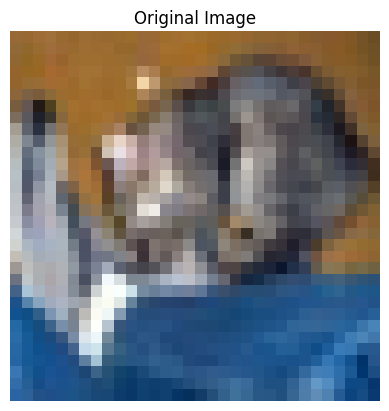

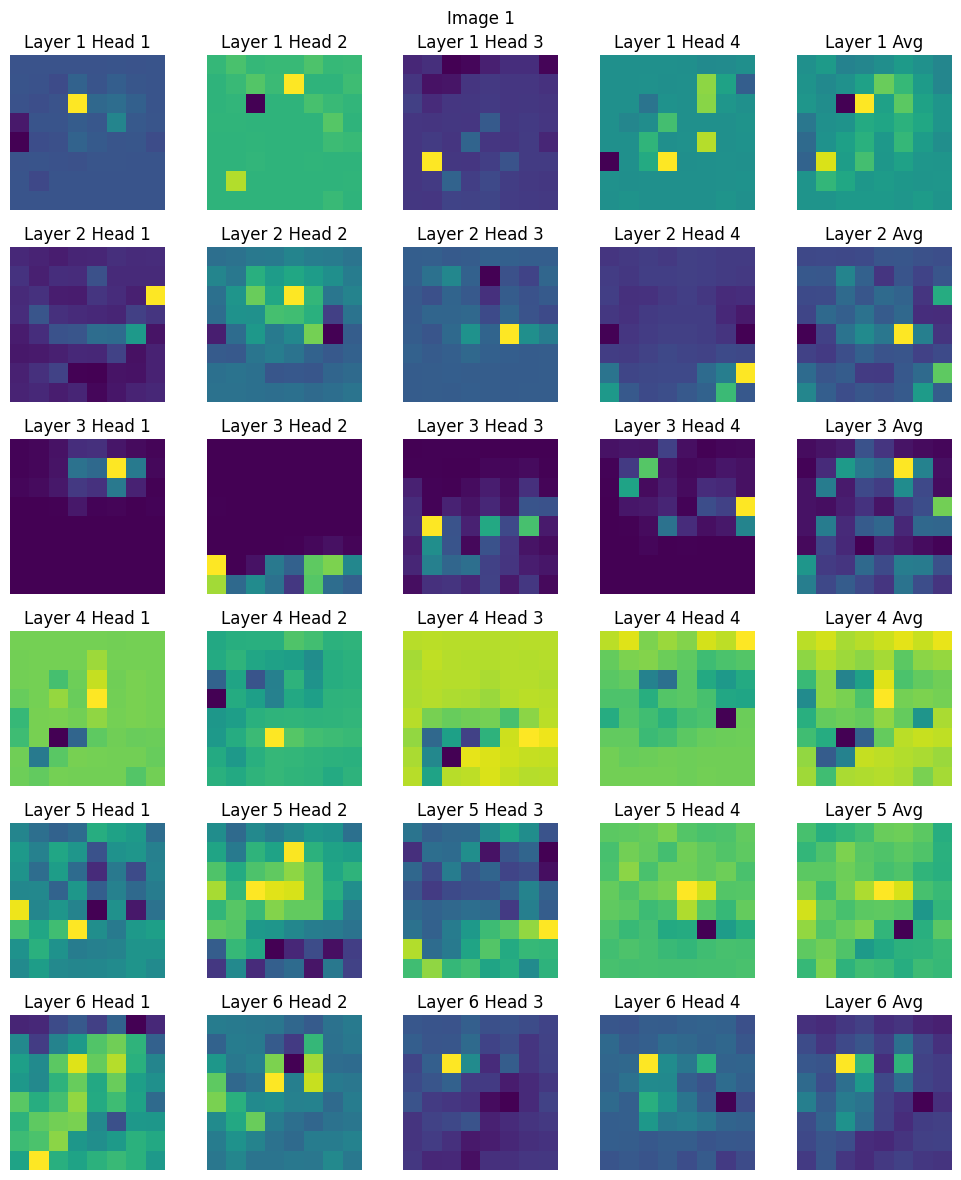

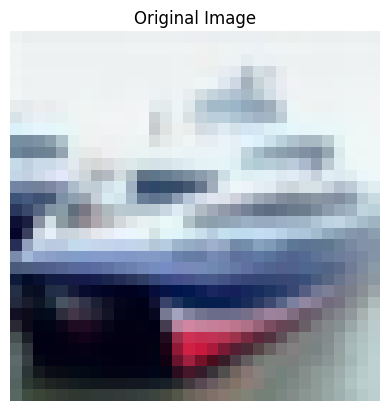

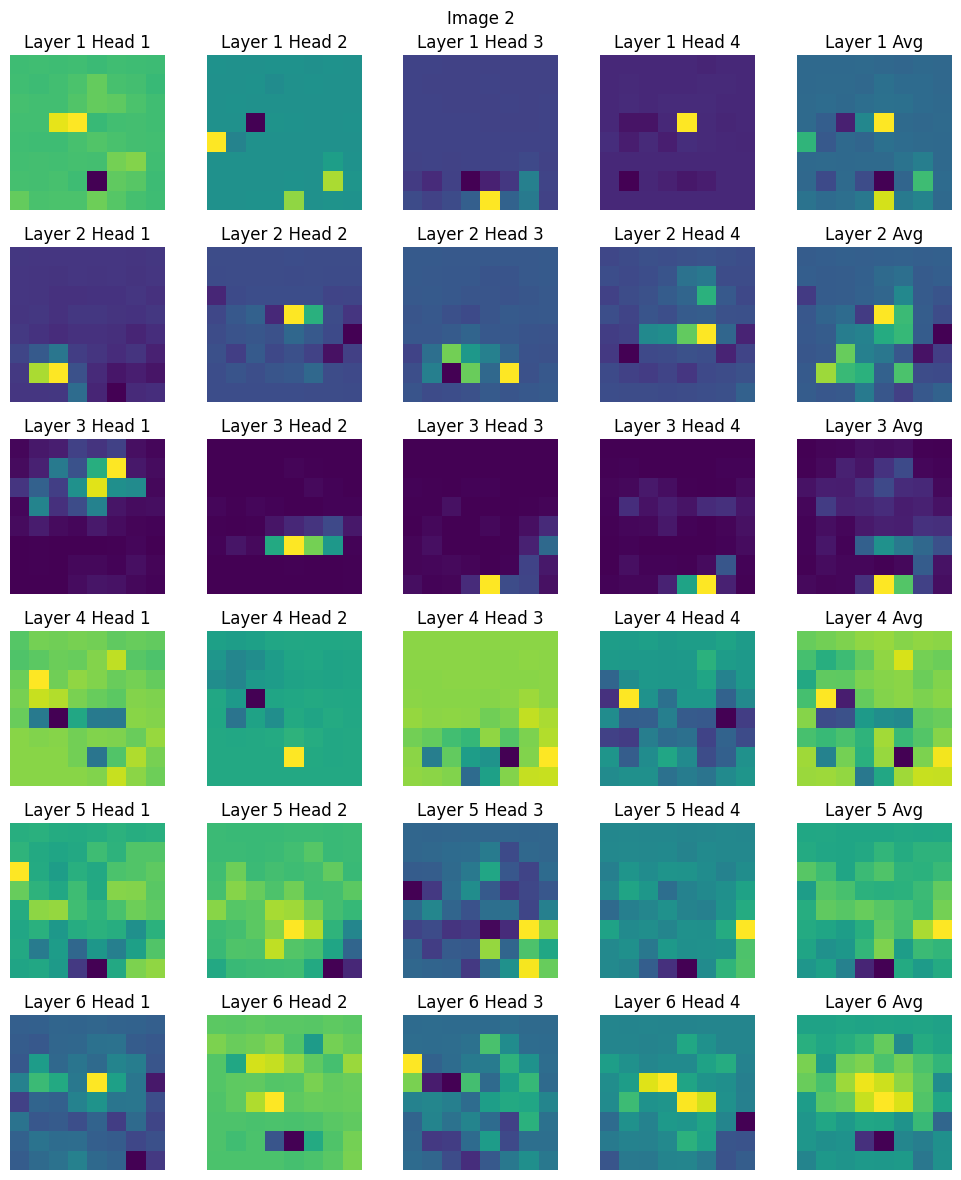

In [17]:
def visualize_attention_maps(model, img, title=""):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # show original image
    img_show = img.permute(1, 2, 0)
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
    plt.imshow(img_show.cpu())
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    
    img = img.unsqueeze(0).to(device) 

    with torch.no_grad():
        outputs = model(img)
        attention_maps = [encoder.attention_map for encoder in model.transformer_encoder]
    
    # for every layer show attention from CLS to all others for each head as well as the average in one plot
    num_layers = len(attention_maps)
    num_heads = attention_maps[0].size(1)
    fig, axs = plt.subplots(num_layers, num_heads + 1, figsize=(10, 2 * num_layers))
    for i in range(num_layers):
        for j in range(num_heads):
            attn_map = attention_maps[i][:, j, 0, 1:].reshape(1, 1, 8, 8).squeeze(0).cpu().numpy()
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
            attn_map = np.transpose(attn_map, (1, 2, 0))
            axs[i, j].imshow(attn_map)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Layer {i + 1} Head {j + 1}')
        avg_attn_map = attention_maps[i][:, :, 0, 1:].mean(dim=1).reshape(1, 1, 8, 8).squeeze(0).cpu().numpy()
        avg_attn_map = (avg_attn_map - avg_attn_map.min()) / (avg_attn_map.max() - avg_attn_map.min())
        avg_attn_map = np.transpose(avg_attn_map, (1, 2, 0))
        axs[i, num_heads].imshow(avg_attn_map)
        axs[i, num_heads].axis('off')
        axs[i, num_heads].set_title(f'Layer {i + 1} Avg')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_attention_maps(model, testset[0][0], "Image 1")
visualize_attention_maps(model, testset[1][0], "Image 2")

### Attention Rollout

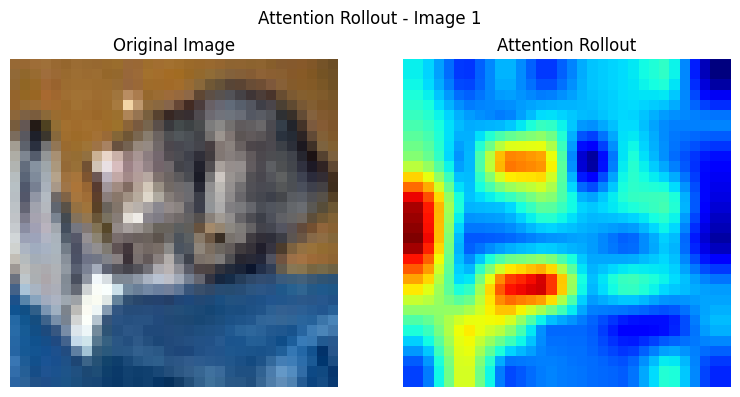

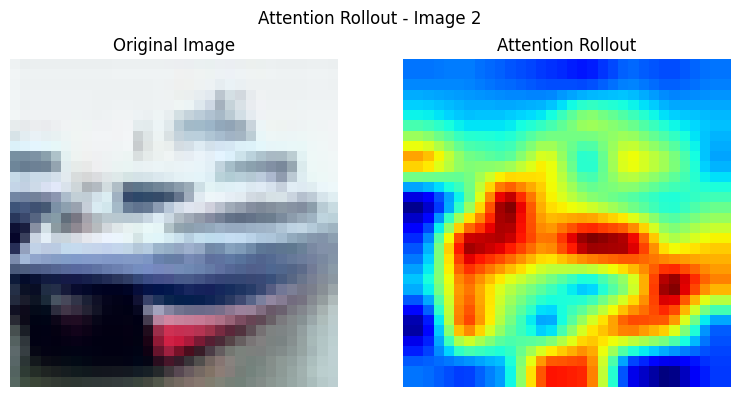

In [18]:
def compute_attention_rollout(model, img, discard_ratio=0.0):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        attention_maps = [encoder.attention_map for encoder in model.transformer_encoder]

    rollout = torch.eye(attention_maps[0].size(-1)).to(device)

    for attn_map in attention_maps:
        avg_attn = attn_map.mean(dim=1)
        if discard_ratio > 0.0:
            num_tokens = avg_attn.size(-1)
            num_discard = int(discard_ratio * num_tokens)
            avg_attn = avg_attn.clone()
            avg_attn[:, :num_discard] = 0
        avg_attn = avg_attn + torch.eye(avg_attn.size(-1)).to(device)
        avg_attn = avg_attn / avg_attn.sum(dim=-1, keepdim=True)
        rollout = torch.matmul(rollout, avg_attn)

    cls_attn = rollout[0, 0, 1:]  
    cls_attn = cls_attn.reshape(1, 1, int(cls_attn.size(0)**0.5), int(cls_attn.size(0)**0.5))
    cls_attn = torch.nn.functional.interpolate(cls_attn, size=(img.size(2), img.size(3)), mode='bilinear', align_corners=False)
    return cls_attn.squeeze(0).cpu().numpy()

def visualize_attention_rollout(model, img, title=""):
    rollout_map = compute_attention_rollout(model, img)

    rollout_map = (rollout_map - rollout_map.min()) / (rollout_map.max() - rollout_map.min())
    rollout_map = rollout_map.transpose(1, 2, 0)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    img_show = img.permute(1, 2, 0)
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())
    axs[0].imshow(img_show.cpu())
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    axs[1].imshow(rollout_map, cmap='jet')
    axs[1].axis('off')
    axs[1].set_title('Attention Rollout')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_attention_rollout(model, testset[0][0], "Attention Rollout - Image 1")
visualize_attention_rollout(model, testset[1][0], "Attention Rollout - Image 2")

### Positional Embedding Visualization

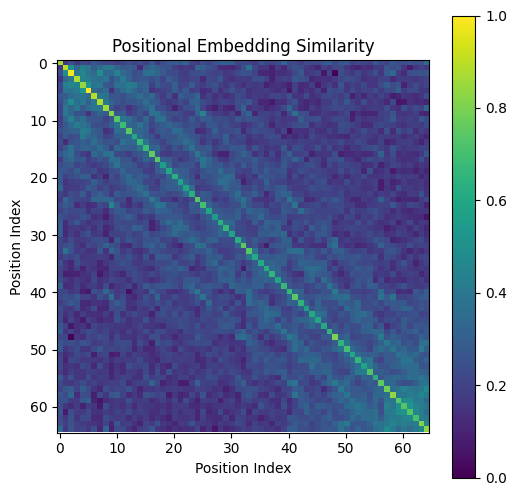

In [19]:
def visualize_positional_embedding_similarity(model, title="Positional Embedding Similarity"):
    pos_embedding = model.position_embedding.squeeze(0).detach().cpu().numpy()
    
    similarity_matrix = np.dot(pos_embedding, pos_embedding.T)
    
    similarity_matrix = (similarity_matrix - similarity_matrix.min()) / (similarity_matrix.max() - similarity_matrix.min())
    
    plt.figure(figsize=(6,6))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Position Index")
    plt.ylabel("Position Index")
    plt.show()

visualize_positional_embedding_similarity(model)